# Trying to fit to the MSSFR from TNG

In [12]:
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

from astropy.table import Table, Column
import os

import matplotlib
from pylab import *
from matplotlib import ticker, cm

def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   
base_dir    = '/Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution/'
save_loc    =  base_dir+'/plots/'
TNGlocation = '/Users/lieke/surfdrive/Documents/CompareCOMPAS/'


############################
##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




In [13]:
from scipy.stats import norm as NormDist

print( NormDist.cdf(0) )



0.5


In [14]:
sf_a_best, sf_b_best, sf_c_best,  sf_d_best = 0.02, 1.48, 4.45, 5.90
# sf_a =0.01687063881834458, sf_b =1.4834054063851878, sf_c =4.448574027958166, sf_d =5.903964702985274

# mu0=0.025, muz=-0.048, alpha_0 = -1.767, alpha_z = alphaz_best, sigma_0=1.125, sigma_z =0.048, 
mu0_best = 0.025
muz_best= -0.048
alpha0_best = -1.767
alphaz_best = 0.0
sigma0_best=1.125
sigmaz_best =0.048

# SFR(z) Madau & Dickinson 2014 shape

In [15]:

########################################################
##
########################################################
def Madau_Dickinson2014(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    Args:
        z             --> [list of floats] List of redshifts at which to calculate things
        a,b,c,d       --> [floats] values to determine the shape of our SFR
    
    Calculates the star-formation rate density as a function of redshift
    Based on the functional form from Madau & Dickinson 2014
    default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
    Madau & Dickinson 2014: a=0.015, b=2.7, c=2.9,  d=5.6
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

    Returns:
        SFR(z) in Msun/yr/Mpc^3
    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) *u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc # Msun year-1 Mpc-3 

    

    

# Get dP/dZ(z)

### New log skewed distribution

metallicity density distribution
Basically this tells us what the probability of finding a certain metallicity at a certain redshift is. 

See also eq. 17 in : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf


# (log) Skew normal dist: 

PDF of the skew normal is defined as:

\begin{equation}
f(Z) = 2 \phi \left(\frac{Z - \mu}{\sigma}\right) \Phi\left(\alpha \frac{Z - \mu}{\sigma} \right)
\end{equation}

$\phi(t)$ and $\Phi(t)$ are the standard ($\sigma = 1$) normal PDF and CDF respectively:

The skew normal is a generalization of the normal distribution, that gets back to a normal distribution for $\alpha = 0$.


***
The PDF for the **log-skew-normal** are then given by just substituting the random variable Z, with ln(Z)


\begin{equation}
f(Z) = 2 \phi(\frac{ln(Z) - \mu}{\sigma}) \Phi(\alpha \frac{ln(Z) - \mu}{\sigma})
\end{equation}

or written out explicitely:

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\int_{-\infty}^{x = \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
\end{equation}

or

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\frac{1}{2} \left[ 1 + erf\left(\frac{ \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right)  }{\sqrt{2}} \right) \right]
\end{equation}


The extra $1/Z$ factors in front of the PDFs come from 
\begin{equation}
\frac{dP}{dZ} = \frac{dP}{d\ln Z} \frac{d\ln Z}{dZ} = \frac{dP}{d\ln Z} \frac{1}{Z}
\end{equation}

***

## Moments
Moments of a probability distribution: the zeroth moment is the total probability (i.e. one), the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. 

equation 23) and 24) from : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf
give the mean and variance of our log-skew-normally distributed random variable Z:


\begin{equation}
E(Z) = 2 e^{\mu} e^{\sigma^2 /2} \Phi(\beta \sigma)
\end{equation}


\begin{equation}
VAR(Z) = 2 e^{2\mu} e^{\sigma^2} (e^{\sigma^1} \Phi(2 \beta \sigma)  - 2\Phi(\beta \sigma)^2)
\end{equation}


with 
\begin{equation}
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2} }
\end{equation}



In [16]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,
                                  alpha_0 = -1.767, alpha_z = 0, 
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
    #                                mu_0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,alpha = -1.767,                               
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    = 0.025    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.05    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 1.25     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.05     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = -1.77    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy

    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh
        
    ##################################
    # Experiment with redshift dependence sigma
    # LOG-LINEAR
    sigma = sigma_0*10**(sigma_z*redshifts)
    #  LINEAR   sigma = sigma_z*redshifts + sigma_0
    
        ##################################
    # Experiment with redshift dependent alpha
    # LINEAR
#     alpha = alpha_0 + (alpha_z*redshifts)
    # LOG-LINEAR (better)
    alpha = alpha_0*10**(alpha_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities))
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = normal_CDF(beta * sigma) # phi is now sigma x alpha dimentional 
    mu_metallicities = np.log(mean_metallicities/(2.*PHI) * 1./(np.exp(0.5*sigma**2) )  ) 

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        #print('step_logZ', step_logZ)
        
    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * normal_PDF((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * normal_CDF(alpha[:,np.newaxis] * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ << Fit does not converge if you multiply by step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity




# First read the TNG data 
## And convert it to a SFDR in Msun/yr/Mpc^-3



In [17]:

######################################
# read TNG data
######################################
with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = 75/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value

##########################################
# "observed" TNG metallicities that we use for our calculations
##########################################
center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
low_bound_Z_ind = np.where(center_Zbin > 1e-5)[0]# index of center_Zbin, where Z > 1e-5
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
bound_Z_ind = np.where(np.logical_and(center_Zbin > 1e-5, center_Zbin < 50*0.014))[0]# index of center_Zbin, where Z < 50 Zsun
tofit_TNG_metals = center_Zbin[bound_Z_ind]   


##########################################
# "obesrved" SFRD in TNG
##########################################
# flip redshifts around so they are in increasing order
TNG_SFRD_inc_z = TNG_SFRD[::-1, :]
# tofit_TNG_SFRD = TNG_SFRD_inc_z[:,low_bound_Z_ind] 
tofit_TNG_SFRD = TNG_SFRD_inc_z[:,bound_Z_ind] 


##########################################
# The redshifts at which we will calc the log-skew-normal
##########################################
#### TNG redshifts corresponding to these lookback times ### 
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_TNG.append(0) # put redshift zero back at the end
redshifts_TNG = np.array(redshifts_TNG)
print('redshifts_TNG')  
print(['%.2f'% (z_fl) for  z_fl in redshifts_TNG[::-1] ] )
# print(np.diff(redshifts_TNG[::-1]), min(np.diff(redshifts_TNG[::-1])), max(np.diff(redshifts_TNG[::-1])))
    
reverse_lookback = Lookbacktimes[::-1]
# print('Reverse_lookback time: ')
# print(['%.2f'% (t_l) for  t_l in reverse_lookback ] )
# print(np.diff(reverse_lookback), min(np.diff(reverse_lookback)), max(np.diff(reverse_lookback)))


redshifts_TNG
['0.00', '0.01', '0.02', '0.03', '0.05', '0.06', '0.07', '0.08', '0.10', '0.11', '0.13', '0.14', '0.15', '0.17', '0.18', '0.20', '0.21', '0.23', '0.24', '0.26', '0.27', '0.30', '0.31', '0.33', '0.35', '0.36', '0.38', '0.40', '0.42', '0.44', '0.46', '0.48', '0.50', '0.52', '0.55', '0.58', '0.60', '0.62', '0.65', '0.68', '0.70', '0.73', '0.76', '0.79', '0.82', '0.85', '0.89', '0.92', '0.95', '1.00', '1.04', '1.08', '1.12', '1.16', '1.21', '1.25', '1.31', '1.36', '1.42', '1.50', '1.54', '1.61', '1.67', '1.75', '1.83', '1.91', '2.01', '2.11', '2.22', '2.33', '2.46', '2.59', '2.75', '2.91', '3.03', '3.31', '3.52', '3.74', '4.05', '4.22', '4.48', '4.72', '5.06', '5.30', '5.61', '5.94', '6.11', '6.62', '7.15', '7.40', '7.78', '8.22', '8.68', '9.28', '9.69', '10.35', '11.42', '12.53', '15.96', '22.11']


# Interpolate the TNG data

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [18]:

#########################################
x = Lookbacktimes[::-1] #redshifts_TNG[::-1]
y = tofit_TNG_metals
z = tofit_TNG_SFRD 
print('np.shape(x), np.shape(y), np.shape(z)', np.shape(x), np.shape(y), np.shape(z))

f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')

# lets interpolate at regular redshift intervals
z_new    = np.arange(0, 10.1, 0.05)                       # new redshifts
xnew     = [cosmo.lookback_time(z).value for z in z_new]  # corresp lookback times
ynew     = tofit_TNG_metals ##np.logspace(-5., -0.5, 100) # new metals

SFRDnew = f_interp(xnew,ynew)

print('np.shape(xnew)', np.shape(xnew),'np.shape(ynew)', np.shape(ynew), 'np.shape(SFRDnew)', np.shape(SFRDnew) )


np.shape(x), np.shape(y), np.shape(z) (100,) (29,) (100, 29)
np.shape(xnew) (202,) np.shape(ynew) (29,) np.shape(SFRDnew) (29, 202)


# Lets start calcuatiing chi^2

In [19]:

##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = redshifts_TNG[::-1],  observed_SFRD = tofit_TNG_SFRD,
                    mu_0_list = 0.026, muz_list =-0.09, sigma0_list = 1.9, sigmaz_list = 1.9, 
                    alpha0_list =-3.3, alphaz_list = 0, returnResiduals = False,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2, normed = False):
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        fit_metals              --> [float]          metals used for fitt
        Redshifts               --> [float]          redshihts used to fit
        observed_SFRD           --> [float]          'observed' SFRD to fit to
        
        mu_0_list    = -0.23    --> [float]          location (mean in normal) at redshift 0
        muz_list = 0.035    --> [float]          redshift evolution of the location
        sigma0_list  = 0.39     --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz_list  = 0.0      --> [float]          redshift evolution of Scale (variance in normal)
        alpha_list   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        sf_a                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square          --> [float ] 
    """
    
    """
    ######################################

    """  
    print('muz_list', muz_list, 'mu_0_list',mu_0_list,\
          'sigma0_list',sigma0_list,'sigmaz_list',sigmaz_list,\
          'alpha0_list',alpha0_list, 'alphaz_list',alphaz_list,\
          'sf_a', sf_a, 'sf_b', sf_b, 'sf_c', sf_c, 'sf_d', sf_d)
        
    #####################################
    # Get the SFR
    # Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
    sfr = Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d) # Msun year-1 Mpc-3 

    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz = muz_list, mu0 = mu_0_list,
                                                  sigma_0= sigma0_list, sigma_z=sigmaz_list, 
                                                  alpha_0 =alpha0_list, alpha_z = alphaz_list,
                                                  metals=fit_metals, redsh = Redshifts)

    #print('np.shape(fit_metals)', np.shape(fit_metals),'np.shape(dPdlogZ)', np.shape(dPdlogZ))
    
    ######################################
    # For each redshift in the TNG data:
    tot_chi_square = 0
    #np.zeros((len(muz_list), len(mu_0_list), len(sigma_list), len(alpha_list)) )
    chi_square_zZ = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    
    #
    Residuals = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    fractional_residuals = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    
    for redshift_i in range(len(redshifts)):
        #print(redshift_i, 'at redshift', redshifts[redshift_i])
        ######################################
        # Now the SFRD = sfr x dPdZ
        #print('sfr[redshift_i]',sfr[redshift_i])
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] 
        #/p_draw_metallicity# Msun year-1 Mpc-3 

        ###################
        if normed:
            obs_norm = np.sum(observed_SFRD[redshift_i,:])
            obs = observed_SFRD[redshift_i,:]/obs_norm
            #print('np.sum(obs)', np.sum(obs))
            
            #model is normed in logZ, so multiply by logZ-binwidth
            model = dPdlogZ[redshift_i,:] *step_logZ 
            #print('np.sum(model)', np.sum(model).flatten() )

        else:
            obs = observed_SFRD[redshift_i,:] 
            #print('step_logZ', step_logZ)
            model = SFRD.value 
        #print('obs', np.shape(obs) , 'model', np.shape(model) )
        
        ###################
        # Zero values are troublesome in Chi_squared!
        min_boundary = 1e-12
        # only fit where model > 1e-12, so set minimum value to 1e-12
        model[model < min_boundary] = min_boundary
        obs[model < min_boundary]   = min_boundary
        # Same for where the observations drop below 1e-12
        model[obs < min_boundary] = min_boundary
        obs[obs < min_boundary]   = min_boundary

        ###################
        # Actual CHI_squared
        #chi_square = ((np.log10(obs) - np.log10(model) )**2)#/np.sum(model) 
        chi_square = ((obs - model )**2)/np.sum(model) 
        #print('chi_square', chi_square, np.sum(chi_square, axis = -1))
        #/np.sum(model)  = divide by the sfr at this redshift
        # append chi square data to matrix
        chi_square_zZ[redshift_i,:] = chi_square
        
        #print('abs(obs-model) , model', abs(obs-model ), model )
        fractional_residual = abs(obs - model)/(model) 
        #print('fractional_residual', fractional_residual)
        fractional_residuals[redshift_i,:] = fractional_residual
        
        Residuals[redshift_i,:] = obs - model
        
        #/sfr[redshift_i].value #/model 
        #print('chi_square', chi_square )
        tot_chi_square += np.sum(chi_square, axis = -1)
        #print('tot_chi_square', np.shape(tot_chi_square), tot_chi_square )


    ######################################
    # Minimum Chi_squared taking all redshift into account
    print(tot_chi_square)
    
    if returnResiduals:
        print('shape chi_square_zZ', np.shape(chi_square_zZ) )
        return chi_square_zZ, tot_chi_square, fractional_residuals, Residuals
    
    return tot_chi_square
#     return chi_square_matix, muz_list[ind[0]], mu_0_list[ind[1]], sigma_list[ind[2]], alpha_list[ind[3]]


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [20]:
#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3,0.01, 2.6, 3.2, 6.2] ):

    # Interpolated TNG data
    chi_square_matix = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T, 
    # Pure TNG data                    #fit_metals=tofit_TNG_metals, Redshifts = redshifts_TNG[::-1], observed_SFRD = tofit_TNG_SFRD, 
                                       muz_list =x0[0], mu_0_list =x0[1],sigma0_list =x0[2], sigmaz_list=x0[3],
                                       alpha0_list = x0[4], #alphaz_list = x0[5],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8],
                                       normed = False)

    return chi_square_matix



# BEST GUESS
#              0.muz, 1.mu0, 2.si0, 3.siz, 4.a0,  5.az, 6.sf_a, 7.sf_b, 8.sf_c, 9.sf_d
# x0 = np.array([-0.05, 0.026, 1.1,   0.0,   -2,    0.05,  0.01,   2.6,    3.2,    6.2])

#              0.muz, 1.mu0, 2.si0, 3.siz, 4.a0, 5.sf_a, 6.sf_b, 7.sf_c, 8.sf_d
x0 = np.array([-0.05, 0.026, 1.1,   0.0,   -2,   0.01,   2.6,    3.2,    6.2])
# FIT
res = minimize(test_chi, x0= x0, method ='nelder-mead', options  = {"maxiter":3000, "disp":True},)

print(res.x)




muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18599120920028228
muz_list -0.052500000000000005 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18080634411995072
muz_list -0.05 mu_0_list 0.0273 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.19761152282969133
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1550000000000002 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.16182473445674406
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.00025 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18448175103649328
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.1 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.19360060141384897
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list

0.06083835387725903
muz_list -0.05879249219019794 mu_0_list 0.023803397783548813 sigma0_list 1.4725848609665357 sigmaz_list 5.582948172273112e-05 alpha0_list -1.351142289828359 alphaz_list 0 sf_a 0.010229389197419884 sf_b 2.2767750695801308 sf_c 3.4276084952261883 sf_d 5.499036253187274
0.06994312469972697
muz_list -0.057025058843400686 mu_0_list 0.024567389601393593 sigma0_list 1.383915383511519 sigmaz_list -0.00041528566749932 alpha0_list -1.6336715952812582 alphaz_list 0 sf_a 0.010252425543402865 sf_b 2.4449246142621672 sf_c 3.323307074954962 sf_d 5.608709839916611
0.06422928072164392
muz_list -0.05827401061941939 mu_0_list 0.023525188495823354 sigma0_list 1.3644343033078243 sigmaz_list -0.00027707442198741033 alpha0_list -1.6140464985144032 alphaz_list 0 sf_a 0.010126796935367005 sf_b 2.407595661166144 sf_c 3.3167736596836823 sf_d 5.866088570051544
0.07080231620085972
muz_list -0.059982472337306 mu_0_list 0.023831479210957452 sigma0_list 1.4064560708147806 sigmaz_list -0.0003332558

0.05846136588191575
muz_list -0.05904438212596125 mu_0_list 0.023994131903963614 sigma0_list 1.3866657469567274 sigmaz_list -0.0004359134327925108 alpha0_list -1.5801386306660028 alphaz_list 0 sf_a 0.010446348121737205 sf_b 2.3923966939978127 sf_c 3.3797509967025725 sf_d 5.930791154808098
0.0620266330121779
muz_list -0.05803399751310734 mu_0_list 0.024408215825126957 sigma0_list 1.332748377140167 sigmaz_list -0.00029852592805364896 alpha0_list -1.6783214504194457 alphaz_list 0 sf_a 0.010469927139348568 sf_b 2.391921817978668 sf_c 3.313454691027144 sf_d 5.662716816515751
0.06667329273965068
muz_list -0.06105457340302678 mu_0_list 0.02429571974802322 sigma0_list 1.4376578533686288 sigmaz_list -0.0004328068599865078 alpha0_list -1.4624954490708226 alphaz_list 0 sf_a 0.010270908052049192 sf_b 2.3594886706577287 sf_c 3.405147254484519 sf_d 5.59231591595859
0.05795299459410508
muz_list -0.0594116142938846 mu_0_list 0.024555284694306193 sigma0_list 1.4009246229316252 sigmaz_list -0.0004185039

0.05236611702165678
muz_list -0.06068356915781911 mu_0_list 0.027640532782011423 sigma0_list 1.4009128976637824 sigmaz_list -0.0006089263387319486 alpha0_list -1.0234103851266019 alphaz_list 0 sf_a 0.010169139392200925 sf_b 2.2722144021927253 sf_c 3.688299137363054 sf_d 6.179562210487587
0.05340856872310087
muz_list -0.06068195983691957 mu_0_list 0.02720760042439784 sigma0_list 1.3981137885147765 sigmaz_list -0.0006146167934965028 alpha0_list -1.1039507081616236 alphaz_list 0 sf_a 0.010289089144367594 sf_b 2.2865471801869837 sf_c 3.640463318667498 sf_d 6.1149123218420485
0.052304649999639304
muz_list -0.05954976383669973 mu_0_list 0.027755039710052616 sigma0_list 1.361486940145683 sigmaz_list -0.0006113144916543084 alpha0_list -1.1072336730895507 alphaz_list 0 sf_a 0.01032657436678772 sf_b 2.289993093360497 sf_c 3.6690572189951416 sf_d 6.301360624038137
0.053364095277716427
muz_list -0.06109169239771373 mu_0_list 0.026477205517997614 sigma0_list 1.40799737214794 sigmaz_list -0.00062280

0.04934953082857744
muz_list -0.06174604616045823 mu_0_list 0.028395708489477894 sigma0_list 1.3563862499642427 sigmaz_list -0.0009568396702673021 alpha0_list -1.1470754271764605 alphaz_list 0 sf_a 0.010561217796621294 sf_b 2.1813518521253856 sf_c 3.785672660774683 sf_d 6.189321197728736
0.049114372790223966
muz_list -0.061771695568936774 mu_0_list 0.02746694551913101 sigma0_list 1.3833586894135284 sigmaz_list -0.0008483196628894896 alpha0_list -1.241753736762485 alphaz_list 0 sf_a 0.010579174364115995 sf_b 2.2302371028387555 sf_c 3.677469354403521 sf_d 6.072030885382842
0.0492933520368825
muz_list -0.0632606866643503 mu_0_list 0.027859148970040888 sigma0_list 1.3850419550911486 sigmaz_list -0.0010744280298393863 alpha0_list -1.1546512328652003 alphaz_list 0 sf_a 0.010535506610584201 sf_b 2.2055881158554955 sf_c 3.7353527895421132 sf_d 6.174555199027299
0.04892345060281368
muz_list -0.06496256113573337 mu_0_list 0.027899798466458153 sigma0_list 1.3926026802684648 sigmaz_list -0.0013015

0.03866059232777364
muz_list -0.07333758911422653 mu_0_list 0.02807318074580372 sigma0_list 1.4272341621614109 sigmaz_list -0.0025319025032139253 alpha0_list -1.524999054948403 alphaz_list 0 sf_a 0.013409942748991897 sf_b 1.838152169684975 sf_c 4.051130328599756 sf_d 6.291845427233401
0.03978503452161183
muz_list -0.07473471332990005 mu_0_list 0.02724836242485295 sigma0_list 1.4744510153541102 sigmaz_list -0.00258634275938277 alpha0_list -1.5719388889568702 alphaz_list 0 sf_a 0.013511712757767556 sf_b 1.8657361818411617 sf_c 3.9900866041961622 sf_d 6.207580538927623
0.03908987257646185
muz_list -0.08107146806823137 mu_0_list 0.02763058893618036 sigma0_list 1.4831877312812916 sigmaz_list -0.0035818019436897747 alpha0_list -1.792914990178749 alphaz_list 0 sf_a 0.014826412990679882 sf_b 1.658317561261887 sf_c 4.160844232434912 sf_d 6.266938981332072
0.03813738646426675
muz_list -0.08154412255273283 mu_0_list 0.027500757183918326 sigma0_list 1.4979366327151014 sigmaz_list -0.00347489263326

0.0335489509094505
muz_list -0.07844055441657491 mu_0_list 0.027461766407242086 sigma0_list 1.5425297454041789 sigmaz_list -0.0032591989746009065 alpha0_list -2.0001188116949726 alphaz_list 0 sf_a 0.01686289178302567 sf_b 1.541793597316182 sf_c 4.319821233083758 sf_d 6.26124614470565
0.0344631831747012
muz_list -0.08075414855926 mu_0_list 0.026132470979381636 sigma0_list 1.5685737044312678 sigmaz_list -0.0031860863482364946 alpha0_list -2.0744308911586895 alphaz_list 0 sf_a 0.017549293046673377 sf_b 1.484326365805288 sf_c 4.306701793235763 sf_d 6.2070510366779805
0.034194117069219966
muz_list -0.07795728156519757 mu_0_list 0.028206323501915744 sigma0_list 1.4934847756609364 sigmaz_list -0.0031191992956996224 alpha0_list -1.6898708298718836 alphaz_list 0 sf_a 0.015118537470259076 sf_b 1.6543134613800388 sf_c 4.252373486772543 sf_d 6.366983000436145
0.0355165708538313
muz_list -0.08097760475877844 mu_0_list 0.026526299392771624 sigma0_list 1.5817530071544559 sigmaz_list -0.00319668725195

0.03195262438337708
muz_list -0.07895773381629118 mu_0_list 0.026560544287509175 sigma0_list 1.6692885297976114 sigmaz_list -0.0028427623566172587 alpha0_list -2.280148096470419 alphaz_list 0 sf_a 0.02087464780260323 sf_b 1.2818142447568113 sf_c 4.619545637920478 sf_d 6.341912620338947
0.03215934679658827
muz_list -0.079655387362695 mu_0_list 0.026628446440702797 sigma0_list 1.6554778381216873 sigmaz_list -0.0029649669963833732 alpha0_list -2.2381366568185976 alphaz_list 0 sf_a 0.020455134494006866 sf_b 1.2987947659331107 sf_c 4.593549228849086 sf_d 6.348079370024021
0.0318688872219087
muz_list -0.08019225355015919 mu_0_list 0.026281217532690006 sigma0_list 1.6721640119103416 sigmaz_list -0.0030907098947821985 alpha0_list -2.331718787312195 alphaz_list 0 sf_a 0.020836552574915547 sf_b 1.2796516524384596 sf_c 4.576560556098679 sf_d 6.361445996532899
0.031664130732528564
muz_list -0.08010950627352353 mu_0_list 0.0259099985818836 sigma0_list 1.6986329176348747 sigmaz_list -0.0031050360062

0.03152314922528686
muz_list -0.07882217531748016 mu_0_list 0.026861000656062152 sigma0_list 1.6668551263389801 sigmaz_list -0.002995809111900352 alpha0_list -2.264087146461347 alphaz_list 0 sf_a 0.020686126768082114 sf_b 1.2985998566365593 sf_c 4.576748565778044 sf_d 6.429232549207601
0.03152236599312301
muz_list -0.07895665146173236 mu_0_list 0.026724152019411425 sigma0_list 1.6731199664994272 sigmaz_list -0.0029439504568009086 alpha0_list -2.280100427843175 alphaz_list 0 sf_a 0.021015251957879365 sf_b 1.2791077504513426 sf_c 4.5963336014736935 sf_d 6.401772185936299
0.0314329670055158
muz_list -0.07992125555928065 mu_0_list 0.026641098275266763 sigma0_list 1.6827032837453513 sigmaz_list -0.0030760051555855207 alpha0_list -2.3464618250208606 alphaz_list 0 sf_a 0.02141266656713376 sf_b 1.2615762660680514 sf_c 4.594669479116094 sf_d 6.427042373864065
0.03146402915816232
muz_list -0.07842820908033556 mu_0_list 0.02683982901035533 sigma0_list 1.6647636406343078 sigmaz_list -0.00294381889

0.031072656951900583
muz_list -0.07677686778043402 mu_0_list 0.02672674321311156 sigma0_list 1.6725951817910651 sigmaz_list -0.0025379950890724434 alpha0_list -2.2889626558324956 alphaz_list 0 sf_a 0.021207720030070765 sf_b 1.2681366820880404 sf_c 4.574923198952225 sf_d 6.319264138227743
0.03102920640446417
muz_list -0.07642008715395969 mu_0_list 0.02658881148788319 sigma0_list 1.684235084107513 sigmaz_list -0.002481180373276454 alpha0_list -2.30928450261019 alphaz_list 0 sf_a 0.021323318281962347 sf_b 1.2714480627101459 sf_c 4.582745114625607 sf_d 6.3434204445426765
0.031111823210631898
muz_list -0.07706934916562391 mu_0_list 0.02626951404219218 sigma0_list 1.6878904864042135 sigmaz_list -0.0024814098206951095 alpha0_list -2.3608721685035388 alphaz_list 0 sf_a 0.021492006208304666 sf_b 1.263846393261181 sf_c 4.5596808644955455 sf_d 6.302089429497316
0.03103859079756284
muz_list -0.07617160856532258 mu_0_list 0.026341210765937997 sigma0_list 1.7020620034914766 sigmaz_list -0.0023525397

0.030625464791815583
muz_list -0.07242208003514886 mu_0_list 0.026987057710633235 sigma0_list 1.659729658669921 sigmaz_list -0.00152748970927614 alpha0_list -2.105187935998909 alphaz_list 0 sf_a 0.021177975992063017 sf_b 1.2880805952789887 sf_c 4.516102882771092 sf_d 6.202092667721548
0.030657805477060755
muz_list -0.07526568615091511 mu_0_list 0.02686708692246361 sigma0_list 1.6576736439762754 sigmaz_list -0.0019945413251695777 alpha0_list -2.1199127143591125 alphaz_list 0 sf_a 0.020982805814064052 sf_b 1.2960127895503426 sf_c 4.526291981273108 sf_d 6.255571016035816
0.030569844894385353
muz_list -0.07635994460142445 mu_0_list 0.026806269088629153 sigma0_list 1.649677674070344 sigmaz_list -0.0020958918432804653 alpha0_list -2.0823392512851697 alphaz_list 0 sf_a 0.02073629582382952 sf_b 1.3087904363508134 sf_c 4.516319603068574 sf_d 6.248953976498157
0.030648410675073654
muz_list -0.07442194469083874 mu_0_list 0.02711392126787507 sigma0_list 1.6582518456866402 sigmaz_list -0.0018377949

0.03011623832682713
muz_list -0.07856991529885515 mu_0_list 0.028074037213960977 sigma0_list 1.6112738484092501 sigmaz_list -0.001984643809782153 alpha0_list -1.9168871754303138 alphaz_list 0 sf_a 0.021448094203390236 sf_b 1.2852749511316603 sf_c 4.48576117915448 sf_d 6.210601357968427
0.030080186178912786
muz_list -0.07893867646111649 mu_0_list 0.027879950757216665 sigma0_list 1.6059789643659026 sigmaz_list -0.0021010952904969163 alpha0_list -1.9412691001378986 alphaz_list 0 sf_a 0.021162858427175864 sf_b 1.2746318170201243 sf_c 4.517754178411195 sf_d 6.166238634780074
0.030179885686377843
muz_list -0.08012273073050065 mu_0_list 0.027886886930885264 sigma0_list 1.602875573494464 sigmaz_list -0.0023624001782390886 alpha0_list -2.0026542706894195 alphaz_list 0 sf_a 0.02130050289437341 sf_b 1.2652894007567466 sf_c 4.511986619206168 sf_d 6.166792864055253
0.03033486296013926
muz_list -0.07955864884256611 mu_0_list 0.02786591363211868 sigma0_list 1.6076889989791974 sigmaz_list -0.002270762

0.029552443528667052
muz_list -0.0794602546906509 mu_0_list 0.029142075453997482 sigma0_list 1.580231021958797 sigmaz_list -0.0014823437739281287 alpha0_list -1.7793406106129055 alphaz_list 0 sf_a 0.022522904543072084 sf_b 1.2539129235659394 sf_c 4.463666537708075 sf_d 6.0548987263094105
0.029593282945100184
muz_list -0.08138304335110935 mu_0_list 0.029361633005394634 sigma0_list 1.5923624073627898 sigmaz_list -0.0019566223195176665 alpha0_list -1.787915397244522 alphaz_list 0 sf_a 0.02288572875335622 sf_b 1.224218318826391 sf_c 4.537451926735795 sf_d 6.200624935806054
0.029543159080308298
muz_list -0.08204740959586271 mu_0_list 0.02996285590021648 sigma0_list 1.5863404812668653 sigmaz_list -0.0018863365231150918 alpha0_list -1.723673441509308 alphaz_list 0 sf_a 0.023507108645315494 sf_b 1.2064366167455454 sf_c 4.544714488964477 sf_d 6.215690747018677
0.02964499924226665
muz_list -0.08210165185340657 mu_0_list 0.029346618397741695 sigma0_list 1.5803468628944126 sigmaz_list -0.002036761

0.029258134478712575
muz_list -0.0836605490184306 mu_0_list 0.029569985362974345 sigma0_list 1.5944068874248718 sigmaz_list -0.0018775342479698158 alpha0_list -1.8402118197472623 alphaz_list 0 sf_a 0.024111205852054198 sf_b 1.1696172000998968 sf_c 4.5617392315698915 sf_d 6.076458041276293
0.0292607622035107
muz_list -0.08582317875307906 mu_0_list 0.030260078252379297 sigma0_list 1.5829355906415186 sigmaz_list -0.002121389447743079 alpha0_list -1.7743619332298806 alphaz_list 0 sf_a 0.0243488522661287 sf_b 1.1664947475549168 sf_c 4.5891218869161845 sf_d 6.145297944727027
0.02918231309479604
muz_list -0.08764461658747807 mu_0_list 0.030351204377307685 sigma0_list 1.579335013121828 sigmaz_list -0.0020622059961648113 alpha0_list -1.7613433735665787 alphaz_list 0 sf_a 0.02503363955448732 sf_b 1.1376622803003982 sf_c 4.593614409459798 sf_d 6.0812370267964795
0.029237965549301942
muz_list -0.08652178624439011 mu_0_list 0.0302156798356032 sigma0_list 1.5825359070103264 sigmaz_list -0.0020558545

0.02917673443792128
muz_list -0.08542514713710539 mu_0_list 0.030050457469461313 sigma0_list 1.5776631852536618 sigmaz_list -0.0020029905803217044 alpha0_list -1.803038277133938 alphaz_list 0 sf_a 0.024036616690547956 sf_b 1.1829557319735169 sf_c 4.552156437030421 sf_d 6.084945778170747
0.029104957773692416
muz_list -0.08505387433033842 mu_0_list 0.03025350074679996 sigma0_list 1.5711889798482195 sigmaz_list -0.0019243259996795541 alpha0_list -1.7484615524387146 alphaz_list 0 sf_a 0.023907792503721277 sf_b 1.1916383022757335 sf_c 4.549101712640418 sf_d 6.083312871376675
0.02911506427744548
muz_list -0.08559078336677763 mu_0_list 0.030224944805937435 sigma0_list 1.5670856631456174 sigmaz_list -0.0019598057408735255 alpha0_list -1.7403113957359138 alphaz_list 0 sf_a 0.023903581741130706 sf_b 1.1875907079597274 sf_c 4.549217454836651 sf_d 6.074453506904581
0.0290898770885375
muz_list -0.08622289750769527 mu_0_list 0.030354057442295294 sigma0_list 1.5589014047465635 sigmaz_list -0.00200655

0.028900987178644706
muz_list -0.08455484161739873 mu_0_list 0.030034665400933684 sigma0_list 1.5705270844706865 sigmaz_list -0.0016908614137200687 alpha0_list -1.7564403055407523 alphaz_list 0 sf_a 0.02319299114611184 sf_b 1.2273888581211867 sf_c 4.493081119257509 sf_d 6.053824289205565
0.02887240382146902
muz_list -0.08412347348264032 mu_0_list 0.030017096356405204 sigma0_list 1.568095169476591 sigmaz_list -0.0015564766504087973 alpha0_list -1.739580618177282 alphaz_list 0 sf_a 0.022884812306351213 sf_b 1.2456479384095784 sf_c 4.466528298282341 sf_d 6.0387180713049275
0.028864375035297648
muz_list -0.08597467552657609 mu_0_list 0.030114727271429748 sigma0_list 1.558510872038453 sigmaz_list -0.001787661289480803 alpha0_list -1.740486615065893 alphaz_list 0 sf_a 0.02309399367890847 sf_b 1.2305087761624862 sf_c 4.482033299352874 sf_d 6.019284744584976
0.028868742805485115
muz_list -0.08559750514470085 mu_0_list 0.030245028746364783 sigma0_list 1.5681580693180877 sigmaz_list -0.001707207

0.02811303603230437
muz_list -0.08976162379173425 mu_0_list 0.032367766008331494 sigma0_list 1.5579637645469333 sigmaz_list -0.0007921302461545744 alpha0_list -1.647085138461558 alphaz_list 0 sf_a 0.02381380198101559 sf_b 1.2285131698617437 sf_c 4.453887443612054 sf_d 5.98075436617375
0.027962675066796575
muz_list -0.09057353369285703 mu_0_list 0.032996786463110064 sigma0_list 1.5564246450296189 sigmaz_list -0.0005009767636440826 alpha0_list -1.6270483913139824 alphaz_list 0 sf_a 0.023947736354921798 sf_b 1.2297466967186352 sf_c 4.444468372156166 sf_d 5.966638514991484
0.027884360886183648
muz_list -0.09118205122828363 mu_0_list 0.0326747204478792 sigma0_list 1.5635025352937317 sigmaz_list -0.0009871246551095875 alpha0_list -1.67257243143411 alphaz_list 0 sf_a 0.024558283231462703 sf_b 1.182633818106948 sf_c 4.513846542377886 sf_d 6.013495851224889
0.027947883227912494
muz_list -0.09186524340767982 mu_0_list 0.03255794818849728 sigma0_list 1.5548522217592344 sigmaz_list -0.000903013463

0.02637255164051224
muz_list -0.11089851390541469 mu_0_list 0.037863692841751034 sigma0_list 1.5596925113137208 sigmaz_list 0.0009873641593888904 alpha0_list -1.6204286706385624 alphaz_list 0 sf_a 0.021862196947700738 sf_b 1.3014777868567289 sf_c 4.396430964456398 sf_d 5.907473271364649
0.02640744597948165
muz_list -0.10528955706408316 mu_0_list 0.03591610182545021 sigma0_list 1.586632161184621 sigmaz_list 2.523882187129684e-05 alpha0_list -1.7745387328664486 alphaz_list 0 sf_a 0.02229574941465194 sf_b 1.2496407637826223 sf_c 4.4991387324715895 sf_d 6.0594426709130556
0.02608629559725454
muz_list -0.10325969147216152 mu_0_list 0.03494925683525804 sigma0_list 1.6061358522797065 sigmaz_list -0.0003779496920833824 alpha0_list -1.8658397163732108 alphaz_list 0 sf_a 0.021942011306438497 sf_b 1.2508337271471648 sf_c 4.531180519312517 sf_d 6.149021252376517
0.02617622419728615
muz_list -0.10593281894304571 mu_0_list 0.036394713505328954 sigma0_list 1.5747349986835757 sigmaz_list 0.00075721801

0.026074454697458466
muz_list -0.10517381029604361 mu_0_list 0.035615542256503555 sigma0_list 1.6114028972728365 sigmaz_list 0.0004683706147285351 alpha0_list -1.8535232122932026 alphaz_list 0 sf_a 0.021073247706495865 sf_b 1.305085518043633 sf_c 4.442782537811173 sf_d 6.064257734795408
0.026222856325155683
muz_list -0.10945566737495982 mu_0_list 0.03635611876713503 sigma0_list 1.5795540625927926 sigmaz_list 5.160899335307186e-05 alpha0_list -1.772507032545167 alphaz_list 0 sf_a 0.02172909574704346 sf_b 1.2675584291768458 sf_c 4.47715254021044 sf_d 6.026633087852728
0.026313101346715405
muz_list -0.10414098572488398 mu_0_list 0.03628893654631757 sigma0_list 1.5738989039153606 sigmaz_list 0.0006541824846534776 alpha0_list -1.6751100730767436 alphaz_list 0 sf_a 0.021640291995815304 sf_b 1.3070906761641579 sf_c 4.407687284231786 sf_d 5.978484122744321
0.026077897524464298
muz_list -0.10306674625450178 mu_0_list 0.035561905810439776 sigma0_list 1.5885249651042868 sigmaz_list 0.000277055569

0.025887198345731256
muz_list -0.1043551547981525 mu_0_list 0.0356822154004561 sigma0_list 1.5960832824455116 sigmaz_list 0.00021249029849824182 alpha0_list -1.7791089550271657 alphaz_list 0 sf_a 0.021501742979213652 sf_b 1.3078336043594176 sf_c 4.43638605722672 sf_d 6.072150733466938
0.02583168882803466
muz_list -0.10373162028312055 mu_0_list 0.035487190989655526 sigma0_list 1.5956052948793715 sigmaz_list 0.00023241754183246763 alpha0_list -1.7918455450490898 alphaz_list 0 sf_a 0.021284662294644638 sf_b 1.3235659693405872 sf_c 4.414810363353409 sf_d 6.061463973139279
0.025824488745281163
muz_list -0.10623063334003108 mu_0_list 0.03609220455718804 sigma0_list 1.6056890516762454 sigmaz_list 0.00011781590349890683 alpha0_list -1.7889032616831604 alphaz_list 0 sf_a 0.021896161264815833 sf_b 1.2838624553927231 sf_c 4.478950422140721 sf_d 6.123249959506344
0.02584999212236968
muz_list -0.10395361478874646 mu_0_list 0.035942217789679654 sigma0_list 1.5844249418504366 sigmaz_list 0.0003133315

0.02574709727519336
muz_list -0.10715754508821351 mu_0_list 0.0357761085592479 sigma0_list 1.6019307970995735 sigmaz_list 0.00010553269235228646 alpha0_list -1.8258000225826656 alphaz_list 0 sf_a 0.020944379872609067 sf_b 1.3352292709231954 sf_c 4.423807798974947 sf_d 6.070872111380169
0.02570073688158318
muz_list -0.10624337213575145 mu_0_list 0.035592894832506036 sigma0_list 1.6024763762219971 sigmaz_list 0.00031460541790222967 alpha0_list -1.8277083733894002 alphaz_list 0 sf_a 0.020629323787234193 sf_b 1.358738185521985 sf_c 4.3856077705496 sf_d 6.037247185755518
0.025687051670619195
muz_list -0.10641940408623488 mu_0_list 0.03569096812199571 sigma0_list 1.5982459880857358 sigmaz_list 0.0005347279610250777 alpha0_list -1.8116033759634966 alphaz_list 0 sf_a 0.020371368526376776 sf_b 1.377288170628944 sf_c 4.3533596948643485 sf_d 5.993689016586124
0.025748174066627705
muz_list -0.10711277638775275 mu_0_list 0.03556130131828294 sigma0_list 1.6063169970257527 sigmaz_list 0.0001459634246

0.02558783604426592
muz_list -0.1048097554078132 mu_0_list 0.03528678721577799 sigma0_list 1.6169080023221407 sigmaz_list 0.0004238280667336216 alpha0_list -1.8846450497279714 alphaz_list 0 sf_a 0.020246895221027468 sf_b 1.3715815077153533 sf_c 4.396031989841376 sf_d 6.062530600664083
0.02558238073363298
muz_list -0.10401635631753793 mu_0_list 0.03536747951127234 sigma0_list 1.6102365774033183 sigmaz_list 0.0004623765995849035 alpha0_list -1.834887107215014 alphaz_list 0 sf_a 0.020615879580523952 sf_b 1.3606929737787472 sf_c 4.393243934900149 sf_d 6.049679850507719
0.025598547663813465
muz_list -0.10468701971164301 mu_0_list 0.03544790364854378 sigma0_list 1.6118337990671245 sigmaz_list 0.00031888449788436337 alpha0_list -1.845968926452826 alphaz_list 0 sf_a 0.020758360040953917 sf_b 1.3474917061758713 sf_c 4.422226965268738 sf_d 6.072893554150943
0.025590090148198085
muz_list -0.1050318641742076 mu_0_list 0.035524942865547526 sigma0_list 1.6182090543900571 sigmaz_list 0.00037509469814

0.025507049275080008
muz_list -0.10302206567678018 mu_0_list 0.03481103245602722 sigma0_list 1.641948040771732 sigmaz_list 0.0007017885970077692 alpha0_list -1.948846271636024 alphaz_list 0 sf_a 0.02033703409664967 sf_b 1.365494169175197 sf_c 4.411445703893575 sf_d 6.070178899033635
0.02548638355134394
muz_list -0.10231431457816664 mu_0_list 0.03465525319510379 sigma0_list 1.6471686049438325 sigmaz_list 0.0007991035909963918 alpha0_list -1.9582655627657983 alphaz_list 0 sf_a 0.020354299177233623 sf_b 1.3642361134987873 sf_c 4.410046148996219 sf_d 6.066631520826391
0.02549180462725954
muz_list -0.10342407275611355 mu_0_list 0.034970462899408195 sigma0_list 1.640144354903604 sigmaz_list 0.000815063736186255 alpha0_list -1.9561610613381988 alphaz_list 0 sf_a 0.020188811547692656 sf_b 1.3759624090519091 sf_c 4.400177733444341 sf_d 6.048433866594952
0.025486239624810746
muz_list -0.10321046465664188 mu_0_list 0.034987943907180824 sigma0_list 1.6427760111642975 sigmaz_list 0.0009976624941573

0.02541500236654512
muz_list -0.10196917945755055 mu_0_list 0.03417212753535108 sigma0_list 1.6653416262276188 sigmaz_list 0.0010233671544784273 alpha0_list -2.028368774912483 alphaz_list 0 sf_a 0.02043373457820153 sf_b 1.3702884057930507 sf_c 4.392536025228811 sf_d 6.03424714917343
0.025394112193351734
muz_list -0.10117025037900657 mu_0_list 0.03378333083589563 sigma0_list 1.678219913004515 sigmaz_list 0.0010753551476840187 alpha0_list -2.070815208065879 alphaz_list 0 sf_a 0.02051632360777092 sf_b 1.3657161687863129 sf_c 4.396314955180692 sf_d 6.041070209626277
0.025407636873212295
muz_list -0.10206661189136372 mu_0_list 0.034199822053221904 sigma0_list 1.6690127135372324 sigmaz_list 0.0011565844758696568 alpha0_list -2.0596195049637522 alphaz_list 0 sf_a 0.020267620792369566 sf_b 1.3801082188665115 sf_c 4.384571863530265 sf_d 6.018261894952093
0.025390555663646865
muz_list -0.10150151758511247 mu_0_list 0.03390689249718637 sigma0_list 1.6828868457270687 sigmaz_list 0.0013202267624844

0.025391312544526673
muz_list -0.10229799003697891 mu_0_list 0.03403791556493823 sigma0_list 1.6778425678207647 sigmaz_list 0.001189521897827442 alpha0_list -2.082500508881922 alphaz_list 0 sf_a 0.020472027595301034 sf_b 1.3721365006638135 sf_c 4.389722121720256 sf_d 6.0174705067070215
0.025363015929529095
muz_list -0.10332075693675244 mu_0_list 0.03433482967985475 sigma0_list 1.6778849041055106 sigmaz_list 0.0012038277243754316 alpha0_list -2.069415441033268 alphaz_list 0 sf_a 0.020694999206124956 sf_b 1.3634081994651988 sf_c 4.397711028479323 sf_d 6.025543219146573
0.025358075674948712
muz_list -0.1039181894940377 mu_0_list 0.03449780261446217 sigma0_list 1.679874971814919 sigmaz_list 0.0012851710055244597 alpha0_list -2.0669620003065168 alphaz_list 0 sf_a 0.020702643615691352 sf_b 1.366835743611615 sf_c 4.393211156774267 sf_d 6.024620324017311
0.025366383570942494
muz_list -0.10188353141076044 mu_0_list 0.03419594359496226 sigma0_list 1.667966296703426 sigmaz_list 0.0010905276293752

0.025358855642404293
muz_list -0.1026553139430148 mu_0_list 0.03408305283141553 sigma0_list 1.6841157577226027 sigmaz_list 0.001315768719936066 alpha0_list -2.094676823958168 alphaz_list 0 sf_a 0.02072163456637403 sf_b 1.3630991963774006 sf_c 4.392585748487342 sf_d 6.008850256578523
0.02535371334374642
muz_list -0.10281281954467245 mu_0_list 0.034148295270314655 sigma0_list 1.68210226650851 sigmaz_list 0.0013015540970197342 alpha0_list -2.092475388453278 alphaz_list 0 sf_a 0.0207750515530988 sf_b 1.3615643749759023 sf_c 4.393602159097466 sf_d 6.005861971635115
0.02535380003638368
muz_list -0.10272284253605928 mu_0_list 0.03411360259461186 sigma0_list 1.6797975408233272 sigmaz_list 0.0012784654526001352 alpha0_list -2.0838282853510135 alphaz_list 0 sf_a 0.0206103818220505 sf_b 1.3692749600891225 sf_c 4.388265922316936 sf_d 6.004358564397012
0.025355920038082135
muz_list -0.10260625993699282 mu_0_list 0.03409064779859243 sigma0_list 1.683617643755266 sigmaz_list 0.0012763157851121197 alp

0.025341091057618736
muz_list -0.1036990372474855 mu_0_list 0.034386732410809126 sigma0_list 1.6824610392394455 sigmaz_list 0.0014132961560908751 alpha0_list -2.081370345118633 alphaz_list 0 sf_a 0.021013644583515984 sf_b 1.3511806380776599 sf_c 4.398156656173576 sf_d 6.005435509834548
0.02534447916995555
muz_list -0.10273381646839178 mu_0_list 0.034108237945848274 sigma0_list 1.682190132625598 sigmaz_list 0.0013042130710136973 alpha0_list -2.0876294150073154 alphaz_list 0 sf_a 0.020850148785512085 sf_b 1.3594865214898046 sf_c 4.395891696356287 sf_d 6.014745679775178
0.025336915614853482
muz_list -0.10267905063966476 mu_0_list 0.034103446566110834 sigma0_list 1.6819446482746585 sigmaz_list 0.0013080506938318004 alpha0_list -2.0847256595053576 alphaz_list 0 sf_a 0.0208283465410853 sf_b 1.3616004165564197 sf_c 4.3952822930795445 sf_d 6.018262679886536
0.025334514524671885
muz_list -0.10268513025379114 mu_0_list 0.03400019722582012 sigma0_list 1.6821684784992672 sigmaz_list 0.001240080772

0.025290100948028815
muz_list -0.10069514262347579 mu_0_list 0.03347784763148757 sigma0_list 1.6934918756126134 sigmaz_list 0.001586372619970045 alpha0_list -2.1093590335883716 alphaz_list 0 sf_a 0.02072372327527233 sf_b 1.3702523521392682 sf_c 4.3937126423386115 sf_d 6.056659216301842
0.025275463431818954
muz_list -0.10121979384752988 mu_0_list 0.03350689234127227 sigma0_list 1.6962770192199077 sigmaz_list 0.0016533330690161104 alpha0_list -2.1220999475097457 alphaz_list 0 sf_a 0.020706560236212083 sf_b 1.3709121223424723 sf_c 4.388999799982427 sf_d 6.050066116234804
0.02527154474630433
muz_list -0.10060061702197201 mu_0_list 0.03344231662340619 sigma0_list 1.6908393307440477 sigmaz_list 0.001627905654321137 alpha0_list -2.1004190139647463 alphaz_list 0 sf_a 0.020793377301401975 sf_b 1.3653311771039367 sf_c 4.391057211714074 sf_d 6.0329538310879585
0.025264522257374623
muz_list -0.09997512831515609 mu_0_list 0.0332694661091211 sigma0_list 1.6899648724544827 sigmaz_list 0.0016705978617

0.025158581847478687
muz_list -0.09777325971061054 mu_0_list 0.03250825761247547 sigma0_list 1.7082894658252408 sigmaz_list 0.0025102229273751752 alpha0_list -2.1740680383406907 alphaz_list 0 sf_a 0.020558599011703267 sf_b 1.3785897340745508 sf_c 4.386704736079766 sf_d 6.024278914186189
0.02511970175887906
muz_list -0.09986664265881343 mu_0_list 0.03304944010070204 sigma0_list 1.7128733111184942 sigmaz_list 0.0027735409013136285 alpha0_list -2.1924326479346856 alphaz_list 0 sf_a 0.021155565641423152 sf_b 1.3499988139736523 sf_c 4.410402620669618 sf_d 5.998472292410909
0.02508542425212337
muz_list -0.10041766396361101 mu_0_list 0.03321064595216017 sigma0_list 1.7140788832186447 sigmaz_list 0.002945872339066664 alpha0_list -2.200599136472408 alphaz_list 0 sf_a 0.02155577309770766 sf_b 1.331558216385413 sf_c 4.421869511487211 sf_d 5.982341396979184
0.025093059382183994
muz_list -0.09790838839034544 mu_0_list 0.03239482279664628 sigma0_list 1.7304079998297728 sigmaz_list 0.0033783602543356

0.024616914638060636
muz_list -0.09657921271635495 mu_0_list 0.03265367118209449 sigma0_list 1.6736783659941663 sigmaz_list 0.0036262864226489482 alpha0_list -2.068315663079889 alphaz_list 0 sf_a 0.020712261392985383 sf_b 1.3617971745353463 sf_c 4.43497023415221 sf_d 6.07165400309702
0.024639478824880927
muz_list -0.09811376685219872 mu_0_list 0.033159469941598727 sigma0_list 1.6767827959538817 sigmaz_list 0.004640449215931354 alpha0_list -2.05884826591451 alphaz_list 0 sf_a 0.02112669944469263 sf_b 1.3483701823883196 sf_c 4.436050249512386 sf_d 6.0349853868488434
0.024520626359028148
muz_list -0.09865631847626322 mu_0_list 0.03352337995953078 sigma0_list 1.6644264333895364 sigmaz_list 0.005247312409953108 alpha0_list -2.009183440474363 alphaz_list 0 sf_a 0.021100737769442962 sf_b 1.352482230159656 sf_c 4.436456481874554 sf_d 6.0469274345067845
0.024422959741348803
muz_list -0.09855326874957318 mu_0_list 0.033184080764236776 sigma0_list 1.6503153634567593 sigmaz_list 0.0036605614328429

0.02324220328284789
muz_list -0.09644190248072151 mu_0_list 0.03375486857426778 sigma0_list 1.5915179609206676 sigmaz_list 0.007103914987725555 alpha0_list -1.9094292327364197 alphaz_list 0 sf_a 0.020486244668850517 sf_b 1.3538882125802223 sf_c 4.502102518085575 sf_d 6.192077825700823
0.02345251330109989
muz_list -0.08792546594760156 mu_0_list 0.03214099513395893 sigma0_list 1.559833141123204 sigmaz_list 0.01016961842305633 alpha0_list -1.8551091248549976 alphaz_list 0 sf_a 0.01973372202727503 sf_b 1.369520589516982 sf_c 4.556174634649283 sf_d 6.289030039459638
0.023157417403059738
muz_list -0.08547926479636764 mu_0_list 0.03138547721064164 sigma0_list 1.5658204087333853 sigmaz_list 0.011784572070245598 alpha0_list -1.9288517100454614 alphaz_list 0 sf_a 0.018908746827728036 sf_b 1.3986871673475418 sf_c 4.574467403394268 sf_d 6.359602501656834
0.02328632315864191
muz_list -0.09109520352661046 mu_0_list 0.03310743133712499 sigma0_list 1.5562726841559211 sigmaz_list 0.009080052818092365 a

0.020638922929272427
muz_list -0.07637906767606423 mu_0_list 0.03068251418181734 sigma0_list 1.449532160501973 sigmaz_list 0.022782985108181567 alpha0_list -1.8692207917645791 alphaz_list 0 sf_a 0.018070834219513207 sf_b 1.4151308866819106 sf_c 4.519592783928232 sf_d 6.261929953767963
0.020548698785394667
muz_list -0.07148848434402119 mu_0_list 0.030551431202001676 sigma0_list 1.3797354769317098 sigmaz_list 0.02428202854162334 alpha0_list -1.681012604155053 alphaz_list 0 sf_a 0.01869217490585038 sf_b 1.3603098661212853 sf_c 4.643058202374307 sf_d 6.458958456332761
0.020409532416656898
muz_list -0.06693648288900522 mu_0_list 0.028479019955578264 sigma0_list 1.4264060928569502 sigmaz_list 0.02436896566226042 alpha0_list -1.8211705486749055 alphaz_list 0 sf_a 0.01840220252848234 sf_b 1.3670972113155506 sf_c 4.618391421033278 sf_d 6.2632160770914
0.020535603570232992
muz_list -0.07317779367945337 mu_0_list 0.030650964053131002 sigma0_list 1.392580285228338 sigmaz_list 0.022585711159876818 

0.018970705230802087
muz_list -0.05772135645234952 mu_0_list 0.029211253965114946 sigma0_list 1.2172981868150208 sigmaz_list 0.035426583599100704 alpha0_list -1.481886676404745 alphaz_list 0 sf_a 0.0175804774177327 sf_b 1.3722797866287921 sf_c 4.669891058719765 sf_d 6.375479417886627
0.019409921745068965
muz_list -0.05804404600909108 mu_0_list 0.029393381250058227 sigma0_list 1.2175868906206788 sigmaz_list 0.03936765657635119 alpha0_list -1.527825491721766 alphaz_list 0 sf_a 0.018055173072602473 sf_b 1.3479866945596086 sf_c 4.738757116972659 sf_d 6.291958356325702
0.019050730431036982
muz_list -0.06018595409904942 mu_0_list 0.029473452533622067 sigma0_list 1.2248360435793764 sigmaz_list 0.03750225816802044 alpha0_list -1.555554751051571 alphaz_list 0 sf_a 0.018522731985281295 sf_b 1.3313220722773216 sf_c 4.680359281874535 sf_d 6.226331753778158
0.018374423818174147
muz_list -0.05718385552291433 mu_0_list 0.029217503727306 sigma0_list 1.1716486246791535 sigmaz_list 0.04125772783916455 a

0.017555861548820172
muz_list -0.05563983113398706 mu_0_list 0.027981212506708944 sigma0_list 1.209936866969243 sigmaz_list 0.03789543225395296 alpha0_list -1.5998837999750326 alphaz_list 0 sf_a 0.017991106686640806 sf_b 1.3657544306964455 sf_c 4.619191478045748 sf_d 5.920579298921156
0.01746952886931162
muz_list -0.05584968962097586 mu_0_list 0.028882398906266343 sigma0_list 1.1739617337602013 sigmaz_list 0.04187931510466755 alpha0_list -1.5505702906224759 alphaz_list 0 sf_a 0.01907025131709216 sf_b 1.30627688466654 sf_c 4.667393057831244 sf_d 5.998370237976587
0.017644068078821087
muz_list -0.051165433840686864 mu_0_list 0.027289207707919545 sigma0_list 1.2045583818180279 sigmaz_list 0.04100938803644519 alpha0_list -1.6059542260216015 alphaz_list 0 sf_a 0.018358925946158712 sf_b 1.342993884858045 sf_c 4.667928115101226 sf_d 6.055452501097626
0.017032011935359716
muz_list -0.05950665855458939 mu_0_list 0.029347781496088354 sigma0_list 1.1870056228118913 sigmaz_list 0.03977194494365397

0.01482664551366072
muz_list -0.03687655524123157 mu_0_list 0.02325387794809486 sigma0_list 1.1287264545151086 sigmaz_list 0.05344940756606778 alpha0_list -1.8856392463767246 alphaz_list 0 sf_a 0.01846847682406396 sf_b 1.3651512427932069 sf_c 4.59412115267159 sf_d 6.076689865143621
0.015283983400004926
muz_list -0.04800223666962064 mu_0_list 0.02550962978849519 sigma0_list 1.1705064537811314 sigmaz_list 0.04785391007419121 alpha0_list -1.9014391406187934 alphaz_list 0 sf_a 0.017382451346556152 sf_b 1.4369462460022153 sf_c 4.517409455880269 sf_d 5.945343401788039
0.014768772335364064
muz_list -0.053413638609955655 mu_0_list 0.026402987032301095 sigma0_list 1.1942058913536822 sigmaz_list 0.04610818808241274 alpha0_list -1.9900299669221555 alphaz_list 0 sf_a 0.017087768626231875 sf_b 1.4694896619636628 sf_c 4.49239971514714 sf_d 6.030441264534225
0.015298861695107923
muz_list -0.04365411596452039 mu_0_list 0.0234687970323378 sigma0_list 1.1920260754111354 sigmaz_list 0.0527654719370232 al

0.014526693367341857
muz_list -0.038497702775213416 mu_0_list 0.023764192614023558 sigma0_list 1.0909010341157357 sigmaz_list 0.053066521131976394 alpha0_list -1.7760417328371765 alphaz_list 0 sf_a 0.01695590906956522 sf_b 1.454097987709956 sf_c 4.526282134458111 sf_d 5.924255966850768
0.01445041996146794
muz_list -0.03827858760056019 mu_0_list 0.023581781971367885 sigma0_list 1.1270121146718908 sigmaz_list 0.05057941449087329 alpha0_list -1.7627129323013317 alphaz_list 0 sf_a 0.01745880350273915 sf_b 1.424395665098841 sf_c 4.5454749279884386 sf_d 5.932802677578858
0.014492945053253653
muz_list -0.0457374935170559 mu_0_list 0.02510935343071609 sigma0_list 1.1481420999041503 sigmaz_list 0.04864380445739566 alpha0_list -1.826827465450446 alphaz_list 0 sf_a 0.016926788001513107 sf_b 1.469685909569443 sf_c 4.4959241541104635 sf_d 5.9153023043460315
0.014496605097772211
muz_list -0.042698158830131464 mu_0_list 0.02422726612543863 sigma0_list 1.1340459139300472 sigmaz_list 0.0493045375177012

0.01438689869055932
muz_list -0.043553495062149145 mu_0_list 0.024381221780976847 sigma0_list 1.1420778894461452 sigmaz_list 0.04910169768200125 alpha0_list -1.8446301689793794 alphaz_list 0 sf_a 0.01699052075920836 sf_b 1.460991842968048 sf_c 4.50160777239739 sf_d 5.960011132580121
0.01428017434156379
muz_list -0.03848089339683995 mu_0_list 0.0234844586605201 sigma0_list 1.106679657407537 sigmaz_list 0.052769446350509466 alpha0_list -1.8142617250207602 alphaz_list 0 sf_a 0.016706622705938784 sf_b 1.4769812518985082 sf_c 4.472433607105373 sf_d 5.861364599076129
0.01436609851731416
muz_list -0.04425249189866451 mu_0_list 0.02429254958624015 sigma0_list 1.1574021660685059 sigmaz_list 0.04863541131939936 alpha0_list -1.8978711337128424 alphaz_list 0 sf_a 0.01703740158479524 sf_b 1.4627048278224506 sf_c 4.493763696289025 sf_d 5.960489063740955
0.014281107444276315
muz_list -0.04315760472571918 mu_0_list 0.024181410704454297 sigma0_list 1.1405962466117747 sigmaz_list 0.04911933379933074 alp

0.014183499350179847
muz_list -0.04350228499163955 mu_0_list 0.024059464533204428 sigma0_list 1.1405122716288942 sigmaz_list 0.04914090660878234 alpha0_list -1.8396371170594876 alphaz_list 0 sf_a 0.016514080086212992 sf_b 1.4969054786066003 sf_c 4.4619638143295415 sf_d 5.944521853996921
0.014174128404963595
muz_list -0.04456313478540007 mu_0_list 0.0242449044480443 sigma0_list 1.1558693279536925 sigmaz_list 0.047880307335802966 alpha0_list -1.8578342500199359 alphaz_list 0 sf_a 0.01676827003077825 sf_b 1.486792081266828 sf_c 4.455714885545115 sf_d 5.912428020601148
0.014189615718451539
muz_list -0.04214874718509794 mu_0_list 0.02389075414233302 sigma0_list 1.1399918462822658 sigmaz_list 0.04928735231630832 alpha0_list -1.82844360873817 alphaz_list 0 sf_a 0.016985809550615592 sf_b 1.4707306506932853 sf_c 4.48163300074142 sf_d 5.931085238954472
0.014183980590454864
muz_list -0.042782031767457124 mu_0_list 0.024140898294019955 sigma0_list 1.1323907320817668 sigmaz_list 0.04925558073871153

0.014143120298615709
muz_list -0.04262658826325351 mu_0_list 0.024028724912535236 sigma0_list 1.1332171990072575 sigmaz_list 0.04932213923376859 alpha0_list -1.8017100251741478 alphaz_list 0 sf_a 0.0168683245483075 sf_b 1.4797181454442259 sf_c 4.4703501495627656 sf_d 5.9333762515904365
0.014137663387341294
muz_list -0.04333120934440605 mu_0_list 0.02418169319052021 sigma0_list 1.1306241253083917 sigmaz_list 0.049035528623157 alpha0_list -1.7893909629371998 alphaz_list 0 sf_a 0.016626880503168025 sf_b 1.493523390934389 sf_c 4.461208972716059 sf_d 5.95545915734953
0.01413200149830214
muz_list -0.043938639189228246 mu_0_list 0.024054065721382335 sigma0_list 1.1392266267315705 sigmaz_list 0.048870832077625034 alpha0_list -1.8285315029217695 alphaz_list 0 sf_a 0.016445556817419604 sf_b 1.5091748814679047 sf_c 4.4398854786514645 sf_d 5.938530105981608
0.014135408922005887
muz_list -0.04363470916370301 mu_0_list 0.024097167592054707 sigma0_list 1.1311318720314136 sigmaz_list 0.048947340755385

0.01409836727625852
muz_list -0.04465574138788524 mu_0_list 0.024486446298024628 sigma0_list 1.1344849083584814 sigmaz_list 0.04871407672486111 alpha0_list -1.7617481621730255 alphaz_list 0 sf_a 0.016700991658969377 sf_b 1.4967226841651757 sf_c 4.442405729689741 sf_d 5.915896834422615
0.014113463904106494
muz_list -0.04409493263558436 mu_0_list 0.02418684394196379 sigma0_list 1.1291082086292428 sigmaz_list 0.0490021127302273 alpha0_list -1.7947342856676176 alphaz_list 0 sf_a 0.016550891120996704 sf_b 1.5080506110514877 sf_c 4.431959906681345 sf_d 5.923359132589846
0.014094407456956922
muz_list -0.044347707983446574 mu_0_list 0.02414353499568654 sigma0_list 1.129179913870614 sigmaz_list 0.04880126625210211 alpha0_list -1.8023326961963297 alphaz_list 0 sf_a 0.016509898340964224 sf_b 1.5128198306010998 sf_c 4.423532488876875 sf_d 5.92551004103332
0.014103759972968095
muz_list -0.044104179745063775 mu_0_list 0.024215219215053038 sigma0_list 1.1305741880601752 sigmaz_list 0.0492016271051724

0.014084354544111952
muz_list -0.044808676126431204 mu_0_list 0.024408532650280708 sigma0_list 1.127155524197541 sigmaz_list 0.048547643453913644 alpha0_list -1.7726155411074342 alphaz_list 0 sf_a 0.016584317535396777 sf_b 1.5097657078970925 sf_c 4.420324623911606 sf_d 5.901702383670548
0.014087653368496397
muz_list -0.04500652958724394 mu_0_list 0.024411025693879543 sigma0_list 1.1281450421887165 sigmaz_list 0.04833102358083675 alpha0_list -1.7684608001051718 alphaz_list 0 sf_a 0.016538683683727486 sf_b 1.5112796416671954 sf_c 4.422542679459337 sf_d 5.909974577306719
0.014081653033620925
muz_list -0.045440345358210815 mu_0_list 0.024433768272481386 sigma0_list 1.1284590761294426 sigmaz_list 0.04800856862512547 alpha0_list -1.7696042297376358 alphaz_list 0 sf_a 0.016453748966437746 sf_b 1.5176290992374275 sf_c 4.414279659426587 sf_d 5.908302951390612
0.014087954953237558
muz_list -0.04438071894185906 mu_0_list 0.02436858758996332 sigma0_list 1.128726385185368 sigmaz_list 0.048711175869

0.014075614182198567
muz_list -0.04495514432202062 mu_0_list 0.024459268206686945 sigma0_list 1.1282895042828525 sigmaz_list 0.048206600075989564 alpha0_list -1.7507308559370518 alphaz_list 0 sf_a 0.016707068496559476 sf_b 1.5019290979304392 sf_c 4.427960830293711 sf_d 5.904618966874384
0.01407424570266252
muz_list -0.04481311247499384 mu_0_list 0.02443163351100408 sigma0_list 1.1275768683217988 sigmaz_list 0.04824086667994498 alpha0_list -1.7487110922775262 alphaz_list 0 sf_a 0.016757800898004133 sf_b 1.4993104840564624 sf_c 4.429030310125022 sf_d 5.901536413575485
0.014074047547125535
muz_list -0.04529383664631193 mu_0_list 0.024563288943290497 sigma0_list 1.1281935028522168 sigmaz_list 0.0481763543201777 alpha0_list -1.746846848818854 alphaz_list 0 sf_a 0.016651969479907498 sf_b 1.5031618651574614 sf_c 4.431212970048977 sf_d 5.913503809756589
0.014074894338089547
muz_list -0.04517493862718307 mu_0_list 0.02449702215556224 sigma0_list 1.1308315068475747 sigmaz_list 0.0480082877456146

0.014063356491596268
muz_list -0.04717845767869659 mu_0_list 0.024776765503299946 sigma0_list 1.1340806829136603 sigmaz_list 0.0469436145374042 alpha0_list -1.7362487378026388 alphaz_list 0 sf_a 0.016804477153220143 sf_b 1.4960616061985117 sf_c 4.432379011169678 sf_d 5.919667582517535
0.014060810280192631
muz_list -0.04798398195726061 mu_0_list 0.024884780642881292 sigma0_list 1.1375181595752606 sigmaz_list 0.046525527782020126 alpha0_list -1.7390720560070632 alphaz_list 0 sf_a 0.01683889463350819 sf_b 1.4933826581883243 sf_c 4.434920747597733 sf_d 5.926107106015095
0.014061794718840734
muz_list -0.04647611451570894 mu_0_list 0.02468822913561604 sigma0_list 1.1287699335128831 sigmaz_list 0.047557808245436047 alpha0_list -1.7384386231843973 alphaz_list 0 sf_a 0.01672074504394106 sf_b 1.5001914998722083 sf_c 4.431977049390621 sf_d 5.92052803274289
0.014059604424014526
muz_list -0.046496686049999805 mu_0_list 0.024696117551924496 sigma0_list 1.1267544604171222 sigmaz_list 0.04777409518015

0.014041466839950108
muz_list -0.04769497367034886 mu_0_list 0.02472449908794539 sigma0_list 1.1317615074095908 sigmaz_list 0.047169485301754605 alpha0_list -1.7504422631375331 alphaz_list 0 sf_a 0.017056462685594395 sf_b 1.4749560377499336 sf_c 4.4590102129178675 sf_d 5.946249707582835
0.014041257848386297
muz_list -0.047765604229647415 mu_0_list 0.024745762487618048 sigma0_list 1.1317387876468197 sigmaz_list 0.04702888927954049 alpha0_list -1.7465319936310997 alphaz_list 0 sf_a 0.016992016850980833 sf_b 1.478673097054509 sf_c 4.455557130621614 sf_d 5.9343948890933245
0.014035632052983754
muz_list -0.04750468617102105 mu_0_list 0.024694104390983435 sigma0_list 1.1296744032181811 sigmaz_list 0.04713964583618485 alpha0_list -1.745136047322326 alphaz_list 0 sf_a 0.017035638679209146 sf_b 1.4742442401551674 sf_c 4.46149293149783 sf_d 5.931141552138477
0.014035042556640039
muz_list -0.04754502612061383 mu_0_list 0.024717503344138733 sigma0_list 1.1314158778456838 sigmaz_list 0.047361799585

0.014023451321469581
muz_list -0.048337536487783786 mu_0_list 0.024731001631919797 sigma0_list 1.1272694772855636 sigmaz_list 0.047388456024031064 alpha0_list -1.7614234515965834 alphaz_list 0 sf_a 0.016960271434877217 sf_b 1.4739193817247949 sf_c 4.467481250454959 sf_d 5.944028678585414
0.014025312169186732
muz_list -0.048467580261918726 mu_0_list 0.024783147637655274 sigma0_list 1.1300383204825903 sigmaz_list 0.0472095714174402 alpha0_list -1.759968782875397 alphaz_list 0 sf_a 0.016881785673282433 sf_b 1.4827008481566857 sf_c 4.452533137464728 sf_d 5.930125317066772
0.014021697878763277
muz_list -0.048895779467417314 mu_0_list 0.024865193283175893 sigma0_list 1.130332127520814 sigmaz_list 0.04712207084295114 alpha0_list -1.7598689118348374 alphaz_list 0 sf_a 0.016768095381424694 sf_b 1.490480880945328 sf_c 4.443863879290724 sf_d 5.927239561823155
0.014025392289353497
muz_list -0.04863372665823402 mu_0_list 0.024750423827785917 sigma0_list 1.1325401715985968 sigmaz_list 0.047139372681

0.014017864449865875
muz_list -0.049464578294242376 mu_0_list 0.02475063920268132 sigma0_list 1.1293114662905066 sigmaz_list 0.04735019693818952 alpha0_list -1.7698679433801217 alphaz_list 0 sf_a 0.01679179001110527 sf_b 1.4858053888712501 sf_c 4.454222611889658 sf_d 5.929767126058019
0.014015459972378711
muz_list -0.04881459149746569 mu_0_list 0.02471605907645866 sigma0_list 1.1302413429121019 sigmaz_list 0.04767802884717353 alpha0_list -1.7796975469698288 alphaz_list 0 sf_a 0.01691988939530486 sf_b 1.4820526832037655 sf_c 4.4504994251854955 sf_d 5.9222062247796075
0.014011617137636486
muz_list -0.04952669759985924 mu_0_list 0.024781528155338163 sigma0_list 1.134572181316356 sigmaz_list 0.047294681903205654 alpha0_list -1.7793946047665923 alphaz_list 0 sf_a 0.01692630468831731 sf_b 1.4827321282497063 sf_c 4.447286982840474 sf_d 5.918213033253317
0.014011685252815825
muz_list -0.04866185696881743 mu_0_list 0.02470719429592439 sigma0_list 1.126104404406067 sigmaz_list 0.0477497337232151

0.014008346477158404
muz_list -0.049015553953436465 mu_0_list 0.02470399172574438 sigma0_list 1.1282610115657685 sigmaz_list 0.047758421390723074 alpha0_list -1.7776399023958829 alphaz_list 0 sf_a 0.01688181007423571 sf_b 1.481906115025153 sf_c 4.450651501594122 sf_d 5.908979010441108
0.014008170903414408
muz_list -0.0492193560846987 mu_0_list 0.0246902168819034 sigma0_list 1.1296752267213952 sigmaz_list 0.0477699535808834 alpha0_list -1.783884759056317 alphaz_list 0 sf_a 0.01690577069764132 sf_b 1.479971418276632 sf_c 4.4535376708137075 sf_d 5.91455343968919
0.014008508880873216
muz_list -0.04883233003222611 mu_0_list 0.02469595069358613 sigma0_list 1.129786121638418 sigmaz_list 0.0477959346349569 alpha0_list -1.779615403271195 alphaz_list 0 sf_a 0.01692535758152775 sf_b 1.4796391097521537 sf_c 4.452548080918315 sf_d 5.9115663626474575
0.01400806338476232
muz_list -0.04850005188859373 mu_0_list 0.024673187272800788 sigma0_list 1.1294646436807851 sigmaz_list 0.047923230978943174 alpha0

0.014007773934620143
muz_list -0.04912577879967002 mu_0_list 0.024727326581626356 sigma0_list 1.130026763686288 sigmaz_list 0.04777418805914275 alpha0_list -1.7830410546144146 alphaz_list 0 sf_a 0.016890465352521648 sf_b 1.4815384794027127 sf_c 4.451221062801173 sf_d 5.912236793297755
0.014007669763721404
muz_list -0.049188268396415685 mu_0_list 0.024734883401763268 sigma0_list 1.1302691217764487 sigmaz_list 0.04769764548715586 alpha0_list -1.7817736997607896 alphaz_list 0 sf_a 0.01691159340723037 sf_b 1.480225477365532 sf_c 4.45201553924905 sf_d 5.9125307456906935
0.01400763228040004
muz_list -0.0492085878467145 mu_0_list 0.024741626922009513 sigma0_list 1.130327803825586 sigmaz_list 0.04765264013275693 alpha0_list -1.780425627793659 alphaz_list 0 sf_a 0.016926608007803726 sf_b 1.4791110729450336 sf_c 4.452927190987028 sf_d 5.912643555224484
0.014007720223399819
muz_list -0.04933106134148142 mu_0_list 0.024747345303171735 sigma0_list 1.130372294915075 sigmaz_list 0.04771458312016928 a

0.014007626561962224
muz_list -0.04922390835069934 mu_0_list 0.02474527279325018 sigma0_list 1.1301385002946165 sigmaz_list 0.04768969755568671 alpha0_list -1.7805430609343182 alphaz_list 0 sf_a 0.01691100890402304 sf_b 1.4805417978798783 sf_c 4.4515383422143096 sf_d 5.912067311017703
0.014007588976552302
muz_list -0.04923978065069787 mu_0_list 0.024742520047248473 sigma0_list 1.1298942539988435 sigmaz_list 0.047764814398743825 alpha0_list -1.782217569384959 alphaz_list 0 sf_a 0.01689828762193067 sf_b 1.4814816896771261 sf_c 4.450718276494603 sf_d 5.910951931676998
0.014007624348790725
muz_list -0.04924070289639215 mu_0_list 0.024742214675003146 sigma0_list 1.1298067728390562 sigmaz_list 0.047721098176240345 alpha0_list -1.7815758096794734 alphaz_list 0 sf_a 0.016905606617160226 sf_b 1.4806133764030047 sf_c 4.451830437746294 sf_d 5.9123661566841665
0.014007582507810533
muz_list -0.049262614496502405 mu_0_list 0.024745061146114973 sigma0_list 1.1295738895120477 sigmaz_list 0.04770883434

0.014007578948189036
muz_list -0.04928934144091253 mu_0_list 0.02475523692100132 sigma0_list 1.1301114190703916 sigmaz_list 0.04770938496715285 alpha0_list -1.781068854869725 alphaz_list 0 sf_a 0.016911023176358893 sf_b 1.4804563160136057 sf_c 4.45173591967524 sf_d 5.91237396044918
0.014007565883964896
muz_list -0.04923910697515993 mu_0_list 0.024748821017604936 sigma0_list 1.1298808612179285 sigmaz_list 0.04772274247552032 alpha0_list -1.7810387375832617 alphaz_list 0 sf_a 0.01691868265606272 sf_b 1.4799540997435252 sf_c 4.452070820162495 sf_d 5.912225454771471
0.014007571896910688
muz_list -0.04927727119746449 mu_0_list 0.024750296682164576 sigma0_list 1.1299602391700259 sigmaz_list 0.04771343317644926 alpha0_list -1.7811553182682414 alphaz_list 0 sf_a 0.016906937762879524 sf_b 1.4806642891129158 sf_c 4.451608594567345 sf_d 5.912208885755059
0.014007559570327824
muz_list -0.0492851524896367 mu_0_list 0.024754773591443097 sigma0_list 1.1300116572919192 sigmaz_list 0.04769549318464515 

0.014007535552365795
muz_list -0.04922265929590654 mu_0_list 0.024749535066035853 sigma0_list 1.129551507284167 sigmaz_list 0.04772911499295494 alpha0_list -1.7794873082257139 alphaz_list 0 sf_a 0.016904705264704292 sf_b 1.4809135353214562 sf_c 4.451227387094332 sf_d 5.912218769481502
0.014007539041021254
muz_list -0.049222127522148613 mu_0_list 0.02474777093844517 sigma0_list 1.1294064191086606 sigmaz_list 0.04773804523700574 alpha0_list -1.7796622962631572 alphaz_list 0 sf_a 0.016904902081603765 sf_b 1.4808561607237345 sf_c 4.4512719557395695 sf_d 5.912031336291795
0.014007539962955692
muz_list -0.04923971569254203 mu_0_list 0.02474922099217848 sigma0_list 1.1295199766459176 sigmaz_list 0.04773655261778309 alpha0_list -1.7800151052192503 alphaz_list 0 sf_a 0.0169022621947637 sf_b 1.4809627610567704 sf_c 4.451312931002928 sf_d 5.912095529435735
0.014007540984500555
muz_list -0.0492220840215748 mu_0_list 0.02474909935653907 sigma0_list 1.1294014061963995 sigmaz_list 0.04774700710363093

0.014007526281670768
muz_list -0.04919879597895227 mu_0_list 0.024745975608408702 sigma0_list 1.129020140864144 sigmaz_list 0.04774641546435407 alpha0_list -1.7779788369456782 alphaz_list 0 sf_a 0.016896546785412893 sf_b 1.4812686007659526 sf_c 4.451041489387686 sf_d 5.912333321916195
0.014007529592798135
muz_list -0.049237458250278546 mu_0_list 0.024750512318291278 sigma0_list 1.1293172963255942 sigmaz_list 0.047726244058953995 alpha0_list -1.77853189465065 alphaz_list 0 sf_a 0.016904431725338197 sf_b 1.480804281954922 sf_c 4.451272535895056 sf_d 5.911997706023982
0.014007529429545912
muz_list -0.04921372086838856 mu_0_list 0.02474638011090144 sigma0_list 1.1293974680634964 sigmaz_list 0.04773887330403945 alpha0_list -1.779126949718457 alphaz_list 0 sf_a 0.0169032126535641 sf_b 1.4808921572582596 sf_c 4.451325090537152 sf_d 5.912047914618009
0.01400752868091507
muz_list -0.049186730440483786 mu_0_list 0.024746174563232505 sigma0_list 1.129198231954132 sigmaz_list 0.04775067062728726 a

0.014007521055438668
muz_list -0.04921143986611857 mu_0_list 0.024746064900566196 sigma0_list 1.1291546531242747 sigmaz_list 0.04774935921764597 alpha0_list -1.778643141793406 alphaz_list 0 sf_a 0.016903997588386687 sf_b 1.4807786066252473 sf_c 4.451519503044423 sf_d 5.912544057332631
0.014007520801762163
muz_list -0.04921710806060674 mu_0_list 0.024748590468827145 sigma0_list 1.129143883571605 sigmaz_list 0.047742804715769895 alpha0_list -1.7782715286283346 alphaz_list 0 sf_a 0.016906036970004062 sf_b 1.4806484685415002 sf_c 4.451637994141642 sf_d 5.912480593944629
0.014007520434109159
muz_list -0.04922936485864074 mu_0_list 0.02475045120781695 sigma0_list 1.12918954239291 sigmaz_list 0.04773579317214467 alpha0_list -1.7782057321662021 alphaz_list 0 sf_a 0.016908016884337088 sf_b 1.480521546595777 sf_c 4.451774436701349 sf_d 5.912609755422366
0.01400752197350198
muz_list -0.04920037133209629 mu_0_list 0.0247456268300044 sigma0_list 1.128999548464357 sigmaz_list 0.04775615071424255 alp

0.014007519191689759
muz_list -0.04919688493939915 mu_0_list 0.024745407316208317 sigma0_list 1.1289984398641248 sigmaz_list 0.0477568477619073 alpha0_list -1.7781800846217366 alphaz_list 0 sf_a 0.016904204627867597 sf_b 1.4807030287724579 sf_c 4.451718643846452 sf_d 5.912663388630418
0.014007519392661165
muz_list -0.049193164979435884 mu_0_list 0.02474546961064815 sigma0_list 1.1290748737821077 sigmaz_list 0.04775726296670795 alpha0_list -1.778315282398781 alphaz_list 0 sf_a 0.016905847513414105 sf_b 1.4806074471721795 sf_c 4.451796558213706 sf_d 5.912648180655033
0.014007519433938864
muz_list -0.049187573857828584 mu_0_list 0.024744347686433625 sigma0_list 1.1290006681429274 sigmaz_list 0.04775921274210375 alpha0_list -1.7781498712144783 alphaz_list 0 sf_a 0.0169045892052178 sf_b 1.4806721861215077 sf_c 4.451782024865487 sf_d 5.912701586061567
0.014007519346258197
muz_list -0.04919724738077975 mu_0_list 0.02474520687247573 sigma0_list 1.1290250528196868 sigmaz_list 0.0477522183048592

0.014007519026316716
muz_list -0.049197028404891305 mu_0_list 0.024745699026950903 sigma0_list 1.1290556936826948 sigmaz_list 0.047752648356812054 alpha0_list -1.7781605124700663 alphaz_list 0 sf_a 0.0169055426902189 sf_b 1.4806193907481524 sf_c 4.451792614196645 sf_d 5.912722677655354
0.01400751896671565
muz_list -0.04919367449219426 mu_0_list 0.024745436544895586 sigma0_list 1.1290198727736 sigmaz_list 0.0477563808353646 alpha0_list -1.7781234225150198 alphaz_list 0 sf_a 0.016905566687820957 sf_b 1.4806188243689422 sf_c 4.451791693372561 sf_d 5.91268282301111
0.014007519034876634
muz_list -0.049197452370023535 mu_0_list 0.02474572258323271 sigma0_list 1.1290642484631594 sigmaz_list 0.0477518102590692 alpha0_list -1.7781879704315389 alphaz_list 0 sf_a 0.016905570323281965 sf_b 1.4806217433751407 sf_c 4.451783188307461 sf_d 5.912707205990074
0.014007518965124227
Optimization terminated successfully.
         Current function value: 0.014008
         Iterations: 1461
         Function e

In [21]:
print(res.success, res.message)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha0_best, alphaz_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4],0
sf_a_best, sf_b_best, sf_c_best, sf_d_best    = res.x[5], res.x[6], res.x[7], res.x[8] #0.01, 2.6, 3.2, 6.2#

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma_0 =%s, sigma_z =%s, alpha0=%s,  alphaz=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best, alpha0_best, alphaz_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )


True Optimization terminated successfully.

BEST FITTING PARAMETERS:
muz =-0.049197452370023535, mu0 =0.02474572258323271, sigma_0 =1.1290642484631594, sigma_z =0.0477518102590692, alpha0=-1.7781879704315389,  alphaz=0
sf_a =0.016905570323281965, sf_b =1.4806217433751407, sf_c =4.451783188307461, sf_d =5.912707205990074


# 3-panel plot 
## 1) Residuals in logZ - redshift plane, 2) TNG-model vs redshift, 3) TNG-model vs metal



In [22]:
# First get the Chi squared matrix (i.e. (obs-mod)^2/sum(mod)) 
# for each redshift and metallicity point used for the interpolation

chi_square_zZ, tot_chi_square, fractional_residuals, Residuals    = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T,
                                   muz_list =muz_best, mu_0_list =mu0_best,sigma0_list = sigma0_best, sigmaz_list= sigmaz_best, alpha0_list = alpha0_best, 
                                   sf_a = sf_a_best, sf_b= sf_b_best, sf_c= sf_c_best, sf_d= sf_d_best,
                                   returnResiduals = True, normed = False)

print('shape chi_square_zZ', np.shape(chi_square_zZ))
print('shape z_new', np.shape(z_new), ' = len redshifts used in fit' )
print('shape SFRDnew.T', np.shape(SFRDnew.T[0,:]) , ' = len metals used in fit')
print('len(ynew)', len(ynew), '= fit_metals' )

print('fractional_residuals', fractional_residuals)


muz_list -0.049197452370023535 mu_0_list 0.02474572258323271 sigma0_list 1.1290642484631594 sigmaz_list 0.0477518102590692 alpha0_list -1.7781879704315389 alphaz_list 0 sf_a 0.016905570323281965 sf_b 1.4806217433751407 sf_c 4.451783188307461 sf_d 5.912707205990074
0.014007518965124227
shape chi_square_zZ (202, 29)
shape chi_square_zZ (202, 29)
shape z_new (202,)  = len redshifts used in fit
shape SFRDnew.T (29,)  = len metals used in fit
len(ynew) 29 = fit_metals
fractional_residuals [[2.10570993e+04 2.65315149e+04 1.01404581e+04 ... 9.99999401e-01
  9.99990476e-01 9.99760062e-01]
 [2.27983221e+04 2.57509450e+04 7.73883383e+03 ... 9.99999461e-01
  9.99991628e-01 9.99795017e-01]
 [3.00474994e+04 2.62991336e+04 6.87373254e+03 ... 9.99999513e-01
  9.99992613e-01 9.99824169e-01]
 ...
 [4.26989826e-01 5.42765216e-01 5.98875193e-01 ... 9.99999814e-01
  9.99999663e-01 9.99999361e-01]
 [4.41406007e-01 5.50785218e-01 6.02608111e-01 ... 9.99999810e-01
  9.99999658e-01 9.99999353e-01]
 [4.5531519

In [23]:
##### Chi square statistic #####
print('Max chi square ', np.amax(chi_square_zZ), ' => log(x) = ',  np.amax(np.log10(chi_square_zZ)))

chi_square_zZ_per_redshift = np.sum(chi_square_zZ, axis =1)
print(np.shape(chi_square_zZ_per_redshift))
print('Min frac residual sumed over metals', np.amin(chi_square_zZ_per_redshift), np.amin(np.log10(chi_square_zZ_per_redshift)))
print('Max frac residual sumed over metals', np.amax(chi_square_zZ_per_redshift), np.amax(np.log10(chi_square_zZ_per_redshift)))
print('Max = {} % '.format(100 * np.amax(chi_square_zZ_per_redshift )) ,'\n\n')


##### residual #####
print('Max residual ', np.amax(Residuals), ' => log(x) = ', np.amax(np.log10(Residuals)))
print('Min residual ', np.amin(Residuals), ' => log(x) = ', np.amin(np.log10(Residuals)))

res_per_redshift = np.sum(Residuals, axis =1)
print(np.shape(Residuals))
print('Min frac residual sumed over metals', np.amin(res_per_redshift), np.amin(np.log10(res_per_redshift)))
print('Max frac residual sumed over metals', np.amax(res_per_redshift), np.amax(np.log10(res_per_redshift)))
print('Max = {} % '.format(100 * np.amax(res_per_redshift)) ,'\n\n' )



##### fractional residual #####
print('Max fractional residual ', np.amax(fractional_residuals), ' => log(x) = ', np.amax(np.log10(fractional_residuals)))

frac_res_per_redshift = np.sum(fractional_residuals, axis =1)
print(np.shape(frac_res_per_redshift))
print('Min frac residual sumed over metals', np.amin(frac_res_per_redshift), np.amin(np.log10(frac_res_per_redshift)))
print('Max frac residual sumed over metals', np.amax(frac_res_per_redshift), np.amax(np.log10(frac_res_per_redshift)))
print('Max = {} % '.format(100 * np.amax(frac_res_per_redshift)) )



Max chi square  9.409618616956107e-05  => log(x) =  -4.02642797868837
(202,)
Min frac residual sumed over metals 1.3699175155482544e-05 -4.863305581471823
Max frac residual sumed over metals 0.00018329481040937052 -3.736849830959656
Max = 0.01832948104093705 %  


Max residual  0.002330256802075108  => log(x) =  nan
Min residual  -0.002597908453507626  => log(x) =  nan
(202, 29)
Min frac residual sumed over metals -0.0047435505847940014 nan
Max frac residual sumed over metals 0.004213221288821464 nan
Max = 0.4213221288821464 %  


Max fractional residual  88545.58610543373  => log(x) =  4.947166916990448
(202,)
Min frac residual sumed over metals 14.777968611048317 1.1696147397661907
Max frac residual sumed over metals 104942.83723508638 5.020952801608889
Max = 10494283.723508637 % 


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


In [24]:
print(np.diff(np.log10(tofit_TNG_metals)) )
log_tofitmetals = np.log10(tofit_TNG_metals)
dlog_fit_metal = np.diff(log_tofitmetals)[0]/2
new_array = 10**np.arange(min(log_tofitmetals), max(log_tofitmetals)+dlog_fit_metal, dlog_fit_metal )
print(tofit_TNG_metals, new_array)

print(tofit_TNG_metals-new_array[::2] < 1e-10 )



[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667]
[1.23389963e-05 1.81111698e-05 2.65835618e-05 3.90193325e-05
 5.72725476e-05 8.40646035e-05 1.23389963e-04 1.81111698e-04
 2.65835618e-04 3.90193325e-04 5.72725476e-04 8.40646035e-04
 1.23389963e-03 1.81111698e-03 2.65835618e-03 3.90193325e-03
 5.72725476e-03 8.40646035e-03 1.23389963e-02 1.81111698e-02
 2.65835618e-02 3.90193325e-02 5.72725476e-02 8.40646035e-02
 1.23389963e-01 1.81111698e-01 2.65835618e-01 3.90193325e-01
 5.72725476e-01] [1.23389963e-05 1.49490353e-05 1.81111698e-05 2.19421831e-05
 2.65835618e-05 3.22067203e-05 3.90193325e-05 4.72730005e-05
 5.72725476e-05 6.93872755e-05 8.40646035e-05 1.01846592e-04
 1.23389963e-04 1.49490353e-04 1.81111698e-04 2.19421831e-0

In [25]:
import matplotlib.gridspec as gridspec

def Residuals_Zz_plane(obs_lookback = [], obs_metal = [], obs_SFRD = [],
                       model_t = None, model_redshift=None, model_y = None, model_SFRD = None,
                       chi_square_matrix = None, tmin = 0.0, tmax = 13.7, 
                       scatter_residuals = True, add_TNG = True, plot_dPdZcontours = True, 
                       neijssel_fit = True, dPdZ_text = None, SFR_text = None,
                       boundkleur = 'orange',COMPASkleur = 'Oranges', TNGkleur = 'YlGnBu', 
                       scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma', savestr ='Residuals',
                       min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)
                      ):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    #     fig, ax = plt.subplots(figsize = (15,10))
    fig = plt.figure(figsize = (15,15))
    gs = gridspec.GridSpec(10, 8)
    gs.update(wspace=0.0, hspace=0.5)
    ax        = plt.subplot(gs[0:4, 1:7])
#     ax.set_facecolor('lightgrey')
    ax_metals = plt.subplot(gs[5:, :3])
    ax_redsh  = plt.subplot(gs[5:, 5:8])
    ######################################
    
    
    ##############################################################################
    # Load TNG data (either original or interpolated)
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Obs_Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        Obs_center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        Obs_cosmic_SFR = Obs_cosmic_SFR.value
        Obs_cosmic_SFR = Obs_cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Obs_Lookbacktimes = obs_lookback
        Obs_center_Zbin   = obs_metal
        Obs_cosmic_SFR    = obs_SFRD
        
    # Convert observed lookback times to observed redshifts
    Obs_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in obs_lookback[1:]] 
    Obs_redshifts.insert(0,0) # put redshift zero at the start
    
    ##############################################################################
    # Top panel: SFRD
    ##############################################################################
    ######################################
    # plot TNG
    if add_TNG:   
        ######################################
        # now actually plot it
        tng_color_map = sns.light_palette("#fe875d", as_cmap=True) # construct smooth cmap from one colour
        tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )      # Pick 7 colours from this smooth colourmap
        tng_color     = ListedColormap(tng_colors)                 # Turn it back into a cmap

        TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin, Obs_cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  

    ##############################################################################
    # Scatter the fit points coloured by their chi squared value
    ##############################################################################
    if scatter_residuals:
        print('scatter_residuals')
        print('Max vlaue of chi square = ',  np.amax(chi_square_matrix), 'or in log10 = ', np.log10(np.amax(chi_square_matrix)))
        
        res_color_map = plt.get_cmap('flare')                   # construct smooth cmap from one colour
        res_colors    = res_color_map(np.linspace(0.,1.0, 7) )  # Pick 7 colours from this smooth colourmap
        res_color     = ListedColormap(res_colors)              # Turn it back into a cmap
        
        # convert redshifts used in fit to lookback times
        for nZ, metal in enumerate(obs_metal[::4]): 
            scat = ax.scatter(Obs_Lookbacktimes[::3], np.full(len(Obs_Lookbacktimes[::3]), metal), cmap = res_color,#'rainbow',
                              c = np.log10(chi_square_zZ[::3,nZ*4]), vmin = -10, vmax = -3, s = 100 )
        cbaxes1 = fig.add_axes([0.825,0.68, 0.02 , 0.2]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label=r'$\log_{10} (\chi^2) = \log_{10} \ \frac{(\mathrm{OBS - MOD})^2 }{ \mathrm{\Sigma MOD} }$')  

        
    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_dPdZcontours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(model_t, model_y, model_SFRD, levels, linewidths=4, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=0)
        ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')

        ###################
        # print all fit values
        ax.text(0.82, 0.88, '$\mathrm{Fit \ parameters:}$',  fontsize=22, transform=plt.gcf().transFigure)
        # dPdZ
        ax.text(0.82, 0.75, dPdZ_text, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
        # SFR
        ax.text(0.82, 0.63, SFR_text, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 25)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if neijssel_fit:
        # We don't have that many metallicities in TNG, which is ugly. 
        # to solve this I'm making a new list of metallicities that contains the TNG fit metallicities
        n_increase = 2
        log_tofitmetals = np.log10(tofit_TNG_metals) # TNG data is equally spaced in log
        dlog_fit_metal = np.diff(log_tofitmetals)[0]/n_increase # we divide the step size by n_increase
        neijssel_metallicities = 10**np.arange(min(log_tofitmetals), max(log_tofitmetals)+dlog_fit_metal, dlog_fit_metal )
        if (tofit_TNG_metals-new_array[::n_increase] > 1e-10 ).any():
            raise ValueError('your new metal array does not contain the old values')
        
        # Get dPdZ   #         neijssel_metals = np.logspace(-5., -0.5, 50)
        neijssel_dPdlogZ, neijssel_redshifts, neijssel_metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu0=0.035, muz=-0.23,
                                                      alpha_0 = 0, alpha_z = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=neijssel_metallicities, redsh = model_redshift)
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(neijssel_redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019:
        neijssel_sfr = Madau_Dickinson2014(neijssel_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        Neijssel_SFRDzZ = neijssel_sfr*neijssel_dPdlogZ.T
        Neijssel_SFRDzZ = Neijssel_SFRDzZ.value
        
        cs_N = ax.contour(t_lookback, neijssel_metallicities, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                          cmap=sns.color_palette('Greys', as_cmap=True),locator=ticker.LogLocator())
        
    ##############################################################################
    # LEFT BOTTOM: SFRDz with metals on x-axis
    ##############################################################################
    redsfift_indces = [0,5,10,20, 40, 60,120,160]#[0,8,15,32, 50, 100, 150, 170]#
    colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours
    LAB = 'TNG'
    plot_lines = []
    
    # Plot a set of redshifts with offset
    for i, redshift_i in enumerate(redsfift_indces):
        if i != 0:
            LAB = None
        shift_step = (len(redsfift_indces)-1)*0.01 - 0.01*i
        ######################################
        # Observed: TNG data
        ax_metals.plot(np.log10(Obs_center_Zbin), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                             lw = 9, c = 'darkgrey', label = LAB)  

        ######################################
        # Model: new SFRD
        l = ax_metals.plot(np.log10(model_y), model_SFRD[:,redshift_i] + shift_step,
                       lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(Obs_redshifts[redshift_i], 3)) )    
        plot_lines.append([l])
        
        ######################################
        # Model: OLD (Neijssel et al. 2019)       
        if neijssel_fit:
            #print('Redshift used in Neijssel: ', np.round(neijssel_redshifts[redshift_i],3))
            ax_metals.plot(np.log10(neijssel_metallicities), Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                             lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)         
        
    ######################################
    # Plot values
    lines = ax_metals.get_lines()
    legend1 = ax_metals.legend(lines[0:1], ['TNG','TNG'],
                     bbox_to_anchor=(0.0, 1.0), loc='lower left')
    ax_metals.add_artist(legend1)
    
    legend2 = ax_metals.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                     bbox_to_anchor=(0.4, 1.0), loc='lower left')
    ax_metals.add_artist(legend2)
    
    legend3 = ax_metals.legend(lines[1::3], ["$%s$"%(np.round(Obs_redshifts[redshift_i], 3)) for redshift_i in redsfift_indces],
                     ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title='$\mathrm{redshift}$')
    
    ax_metals.set_xlabel('$\log_{10}(Z)$', size =25)
    ax_metals.set_ylabel('$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]', size =25)

    ax_metals.set_ylim(-0.005, 0.08)
    ax_metals.set_xlim(-4, -0.5)
    
    
    ##############################################################################
    # Right BOTTOM: SFRDz with redshift on x-axis
    ##############################################################################
    metal_indices = [0,8,12,15,17,20,21,24]
    colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours
    LAB = 'TNG'
    plot_lines = []
    
    # Plot a set of redshifts with offset
    for j, metal_i in enumerate(metal_indices):
        if i != 0:
            LAB = None
        shift_step = (len(metal_indices)-1)*0.01 - 0.01*j 
        ######################################
        # Observed: TNG data
        ax_redsh.plot(Obs_redshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                             lw = 9, c = 'darkgrey', label = LAB)  

        ######################################
        # Model: NEW SFRD
        l = ax_redsh.plot(model_redshift, model_SFRD[metal_i,:] + shift_step,
                       lw = 4, ls = '--', c = colors[j] )    
        plot_lines.append([l])
        
        ######################################
        # Model: OLD (Neijssel et al. 2019)       
        if neijssel_fit:
            #print('Metal used in Neijssel: ', np.log10(neijssel_metallicities[metal_i*n_increase]) )
            ax_redsh.plot(neijssel_redshifts, Neijssel_SFRDzZ[metal_i*n_increase,:] + shift_step,
                             lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)      
        
    ######################################
    # Plot values
    lines = ax_redsh.get_lines()
    legend1 = ax_redsh.legend(lines[0:1], ['TNG','TNG'],
                     bbox_to_anchor=(0.0, 1.0), loc='lower left')
    ax_redsh.add_artist(legend1)
    
    legend2 = ax_redsh.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                     bbox_to_anchor=(0.4, 1.0), loc='lower left')
    ax_redsh.add_artist(legend2)
    
    legend3 = ax_redsh.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]), 1)) for metal_i in metal_indices],
                     ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title='$\log_{10}Z$')
    
    ax_redsh.set_xlabel('$\mathrm{redshift}$', size =25)
    ax_redsh.set_ylabel('$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]', size =25)
    
    ax_redsh.set_ylim(-0.005, 0.075)
    
    
    ##############################################################################
    print('saving here', save_loc + 'SFRD_FIT_evaluation_compare_1.pdf')
    plt.savefig(save_loc + 'SFRD_FIT_evaluation_compare_1.pdf',  bbox_inches='tight')
    
    plt.show()


Using interpolated TNG


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFRD_FIT_evaluation_compare_1.pdf


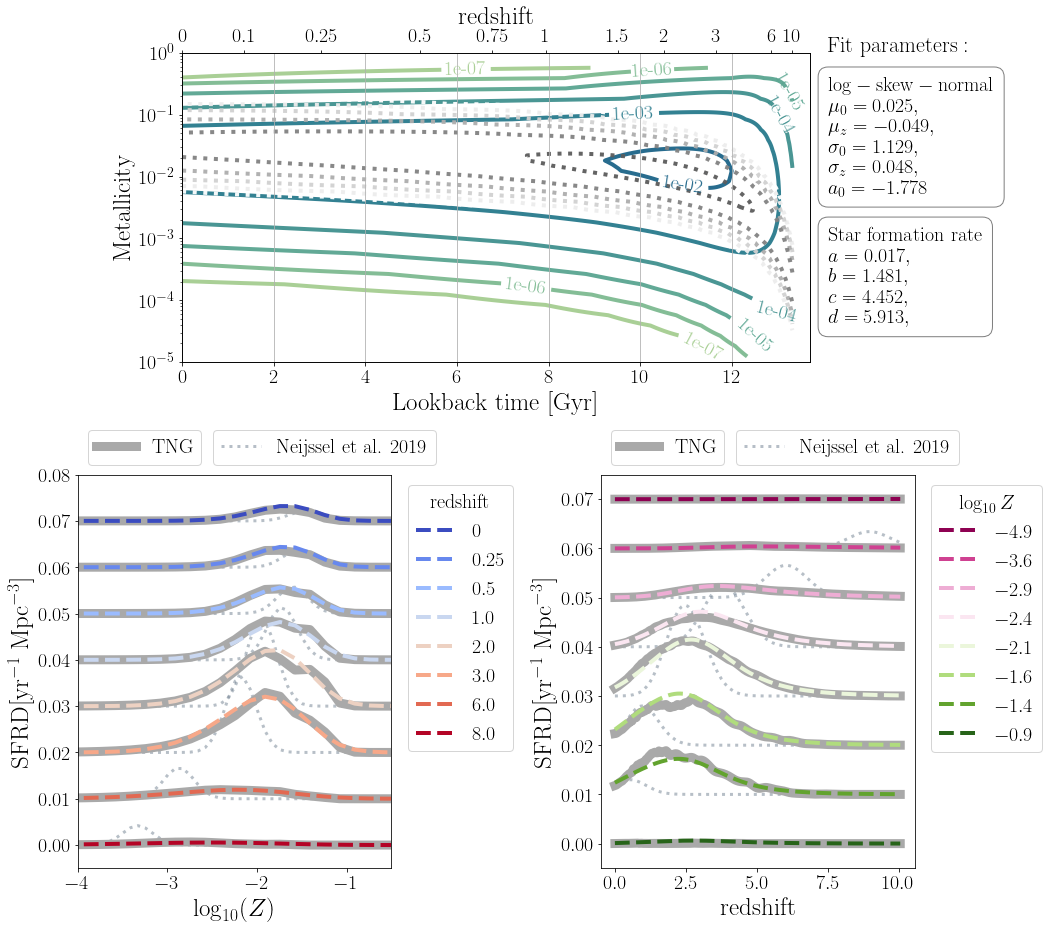

In [28]:
#####################################
# Get dPdZ 
# Make sure to calculate it at the same redshifts/metals as used in your fit
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = z_new)#redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)
# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
MSSFR = sfr*dPdlogZ.T
#####################################

fit_values_string = '$\mathrm{log-skew-normal}$'+'\n'+\
                    '$\mu_0=%s,$'%(np.round(mu0_best,3)) +'\n'+\
                    '$\mu_z=%s,$'%(np.round(muz_best,3)) +'\n'+\
                    '$\sigma_0=%s,$'%(np.round(sigma0_best,3)) +'\n'\
                    '$\sigma_z=%s,$'%(np.round(sigmaz_best,3)) +'\n'\
                    '$a_0=%s$'%(np.round(alpha0_best,3))

SFR_fit_string = '$\mathrm{Star \ formation \ rate}$'+'\n'+\
                 '$a=%s,$'%(np.round(sf_a_best,3)) +'\n'+\
                 '$b=%s,$'%(np.round(sf_b_best,3)) +'\n'+\
                 '$c=%s,$'%(np.round(sf_c_best,3)) +'\n'\
                 '$d=%s,$'%(np.round(sf_d_best,3))

Residuals_Zz_plane(obs_lookback = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   model_t = t_lookback.value, model_redshift=redshifts, model_y = metallicities, model_SFRD =MSSFR.value,
                   chi_square_matrix = chi_square_zZ,
                   scatter_residuals = False, add_TNG = False, 
                   plot_dPdZcontours = True, neijssel_fit = True,
                   COMPASkleur="crest", dPdZ_text = fit_values_string, SFR_text = SFR_fit_string)#light:k#404040 fe1100



# Using more narrow distribution


1.1290642484631594 0.0477518102590692
Using interpolated TNG


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFRD_FIT_evaluation_compare_1.pdf


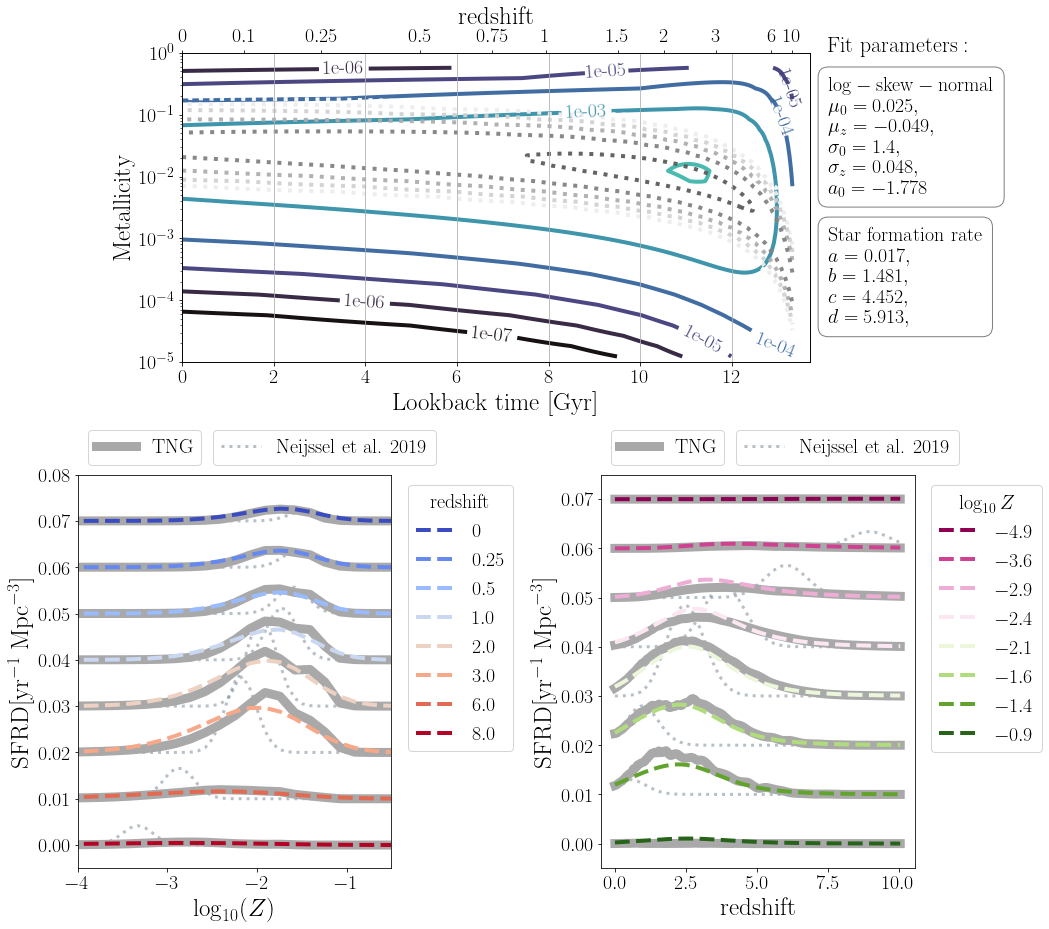

In [46]:
print( sigma0_best, sigmaz_best)

alpha_0_used = alpha0_best
sigma0_used  = 1.4#sigma0_best
sigma_z_used = sigmaz_best
#####################################
# Get dPdZ 
# Make sure to calculate it at the same redshifts/metals as used in your fit
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,alpha_0 = alpha_0_used, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_used, sigma_z =sigma_z_used, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = z_new)#redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)
# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
MSSFR = sfr*dPdlogZ.T
#####################################

fit_values_string = '$\mathrm{log-skew-normal}$'+'\n'+\
                    '$\mu_0=%s,$'%(np.round(mu0_best,3)) +'\n'+\
                    '$\mu_z=%s,$'%(np.round(muz_best,3)) +'\n'+\
                    '$\sigma_0=%s,$'%(np.round(sigma0_used,3)) +'\n'\
                    '$\sigma_z=%s,$'%(np.round(sigma_z_used,3)) +'\n'\
                    '$a_0=%s$'%(np.round(alpha_0_used,3))

SFR_fit_string = '$\mathrm{Star \ formation \ rate}$'+'\n'+\
                 '$a=%s,$'%(np.round(sf_a_best,3)) +'\n'+\
                 '$b=%s,$'%(np.round(sf_b_best,3)) +'\n'+\
                 '$c=%s,$'%(np.round(sf_c_best,3)) +'\n'\
                 '$d=%s,$'%(np.round(sf_d_best,3))

Residuals_Zz_plane(obs_lookback = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   model_t = t_lookback.value, model_redshift=redshifts, model_y = metallicities, model_SFRD =MSSFR.value,
                   chi_square_matrix = chi_square_zZ,
                   scatter_residuals = False, add_TNG = False, 
                   plot_dPdZcontours = True, neijssel_fit = True,
                   COMPASkleur="mako", dPdZ_text = fit_values_string, SFR_text = SFR_fit_string)#light:k#404040 fe1100



# MSSFR compared to TNG

In [27]:

def metal_contours_TNG(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7, 
                                obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False, fid_contours=False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    # Create the Figure
    fig, ax = plt.subplots(figsize = (15,10))
    
    ##############################################################################

    ######################################
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        cosmic_SFR = cosmic_SFR.value
        cosmic_SFR = cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Lookbacktimes = obs_redshift
        center_Zbin   = obs_metal
        cosmic_SFR    = obs_SFRD
        
    if add_TNG:
        # construct cmap
        flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#
        #         tng_color = ListedColormap(sns.color_palette(flatui).as_hex())
        # construct smooth cmap from one colour
        tng_color_map = sns.light_palette("#fe875d", as_cmap=True)
        # Pick 7 colours from this smooth colourmap
        tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )
        # Turn it back into a cmap
        tng_color     = ListedColormap(tng_colors)


        TNG = ax.pcolormesh(Lookbacktimes, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=10)
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if fid_contours:
        # Get dPdZ   
        fid_dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu0=0.035, muz=-0.23,
                                                      alpha_0 = 0, alpha_z = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=[], redsh = [])
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019: a=0.01, b=2.6, c=3.2,  d=6.2
        print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
        fid_sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        fid_MSSFR = fid_sfr*fid_dPdlogZ.T
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        fidCOMPAS_cmap = sns.color_palette("Blues", as_cmap=True)
        
        cs = ax.contour(t_lookback, metallicities, fid_MSSFR, levels, linewidths=3.5, cmap=fidCOMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')

        
        
    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
#     ###################
#     #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 35)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 35)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 35)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    plt.title(title)
    print('saving here', save_loc + 'FIT_RedshiftMetal_Plane.pdf')
    plt.savefig(save_loc + 'FIT_RedshiftMetal_Plane.pdf',  bbox_inches='tight')
    
    plt.show()


# Show what our new fit looks like in the Z,z plane

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


 sf_a_best=0.016579731761621523, sf_b_best=1.5079689886898067, sf_c_best=4.420068453108835, sf_d_best=5.8290212609177825
(202,) (29,) (29, 202)
Using interpolated TNG
 sf_a_best=0.016579731761621523, sf_b_best=1.5079689886898067, sf_c_best=4.420068453108835, sf_d_best=5.8290212609177825


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/FIT_RedshiftMetal_Plane.pdf


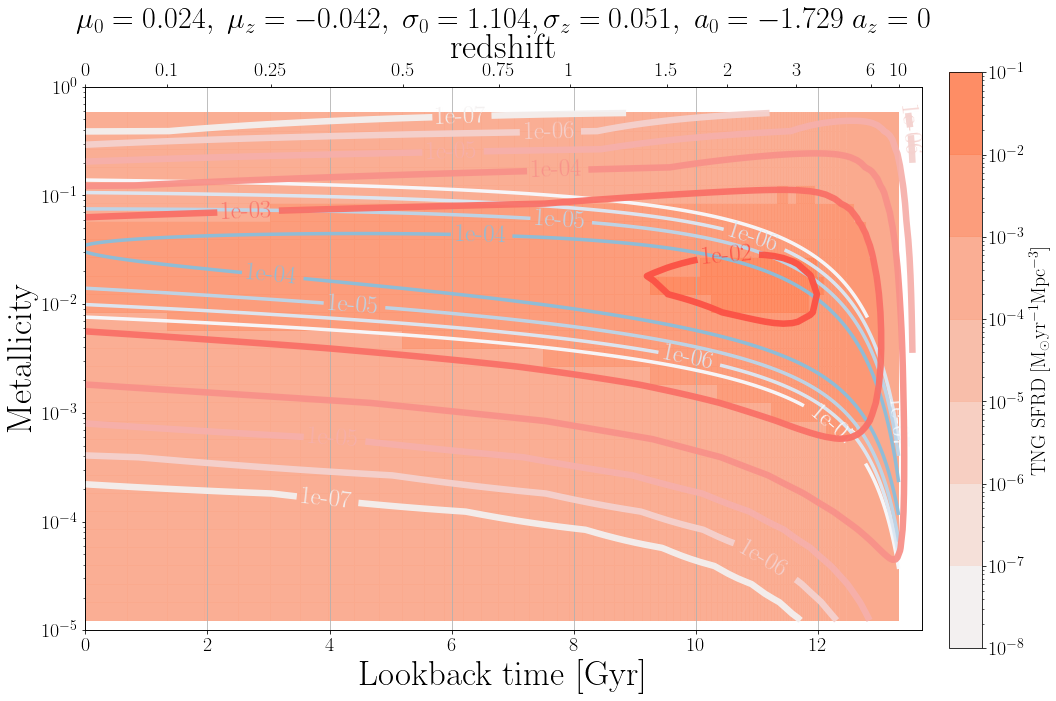

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [91]:
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'


Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_0=%s \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3),\
                                                                       np.round(sigma0_best,3),np.round(sigmaz_best,3),\
                                                                       np.round(alpha0_best,3),np.round(alphaz_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR.value, plot_contours = True,
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   COMPASkleur="light:#fe1100", title = Title, fid_contours=True)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

# Test our newly found fit!




BEST FITTING PARAMETERS:
muz=-0.043903039483663794, mu0=0.023898696355024562, sigma_0 =1.2059153668930396, sigma_z =0.0390851425896455, alpha=-1.7671626767422142


Using interpolated TNG data
['0.00', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95', '1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50', '1.55', '1.60', '1.65', '1.70', '1.75', '1.80', '1.85', '1.90', '1.95', '2.00', '2.05', '2.10', '2.15', '2.20', '2.25', '2.30', '2.35', '2.40', '2.45', '2.50', '2.55', '2.60', '2.65', '2.70', '2.75', '2.80', '2.85', '2.90', '2.95', '3.00', '3.05', '3.10', '3.15', '3.20', '3.25', '3.30', '3.35', '3.40', '3.45', '3.50', '3.55', '3.60', '3.65', '3.70', '3.75', '3.80', '3.85', '3.90', '3.95', '4.00', '4.05', '4.10', '4.15', '4.20', '4.25', '4.30', '4.35', '4.40', '4.45', '4.50', '4.55', '4.60', '4.65', '4.70', '4.75', '4.80', '4.85', '4.90', '4.95', '5.00'

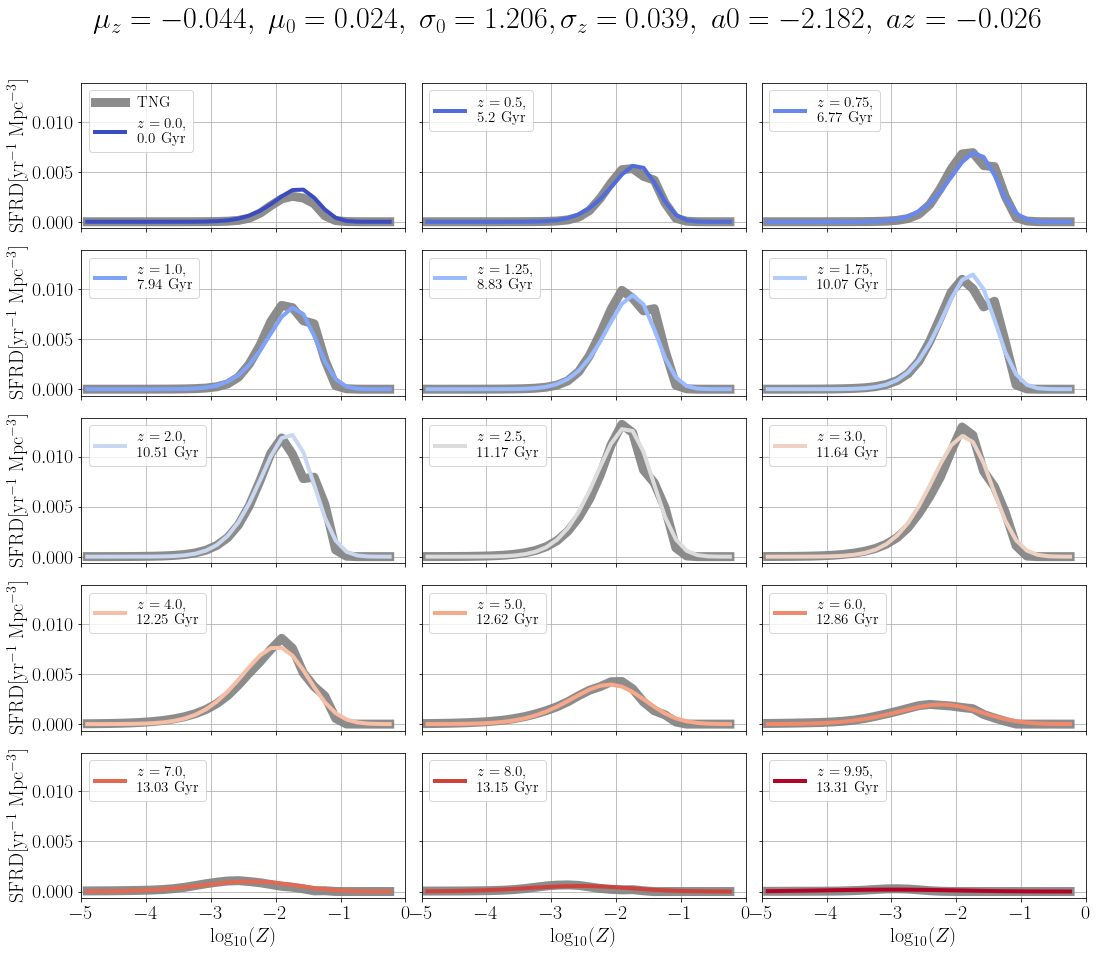

In [254]:

######################################
# BEST FITTING PARAMETERS:
print('\nBEST FITTING PARAMETERS:')
print('muz=%s, mu0=%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best,alpha_best) )
print('\n')

######################################
normed = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    redsfift_indces = [0,10,15,
                       20,25,35,
                       40,50,60,
                       80,100,120,
                       140,160,199]
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    redsfift_indces = [0,8,15,32,40,48,58,60,66,70,75,80,88,91,95]


#####################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)
t_lookback = cosmo.lookback_time(redshifts)
print(['%.2f'% (z_fl) for  z_fl in redshifts ] )
##########
# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

##########
colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours



######################################
# PLOT it!
# Draw the figure
#####################################
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for z, redshift_i in enumerate(redsfift_indces):
    linestyles = ['-', ':', '--', '-.', ':']
    ######################################
    # "OBSERVATIONS" = TNG 
    ######################################
    row  = int(floor(z/3) )
    col  = z - row*3
    #print('row, col', row, col)
    
    if z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[redshift_i,:])
        normed_TNG_SFRD = obs_SFRD[redshift_i,:]/obs_norm
        ax[row,col].plot(np.log10(obs_metal), normed_TNG_SFRD, 
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)   
        
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(np.log10(obs_metal), obs_SFRD[redshift_i,:] ,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)    

    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] # Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        model = dPdlogZ[redshift_i,:] *step_logZ 
        ax[row,col].plot(np.log10(metallicities), model, lw = 4, ls = linestyles[0], c = colors[z],
                 label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i].value,2) ) )    
    
    # Plot the full fit, including params for SFR(z)
    else:
        print('sfr[redshift_i]',sfr[redshift_i])
        ax[row,col].plot(np.log10(metallicities), SFRD, lw = 4, ls = linestyles[0], c = colors[z],
             label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i].value,2) ) )    

    ax[row,col].legend(fontsize = 15, loc='upper left')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-5, 0.)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\log_{10}(Z)$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a0=%s, \ az=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha0_best,3), np.round(alphaz_best,3) )
plt.suptitle(title, y = 0.95)


print('saving here',save_loc + 'TNGfit_redshift_slices.pdf')
plt.savefig(save_loc + 'TNGfit_redshift_slices.pdf',  bbox_inches='tight')
    

plt.show()


# at fixed metallicity


BEST FITTING PARAMETERS:
muz =-0.043903039483663794, mu0 =0.023898696355024562, sigma0 =1.2059153668930396,sigmaz =0.0390851425896455, alpha=-1.7671626767422142


Using interpolated TNG data
obs_metal [-4.90872016 -4.7420535  -4.57538683 -4.40872016 -4.2420535  -4.07538683
 -3.90872016 -3.7420535  -3.57538683 -3.40872016 -3.2420535  -3.07538683
 -2.90872016 -2.7420535  -2.57538683 -2.40872016 -2.2420535  -2.07538683
 -1.90872016 -1.7420535  -1.57538683 -1.40872016 -1.2420535  -1.07538683
 -0.90872016 -0.7420535  -0.57538683 -0.40872016 -0.2420535 ]
(202,) (29,) (29, 202)
saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/TNGfit_redshift_slices.pdf


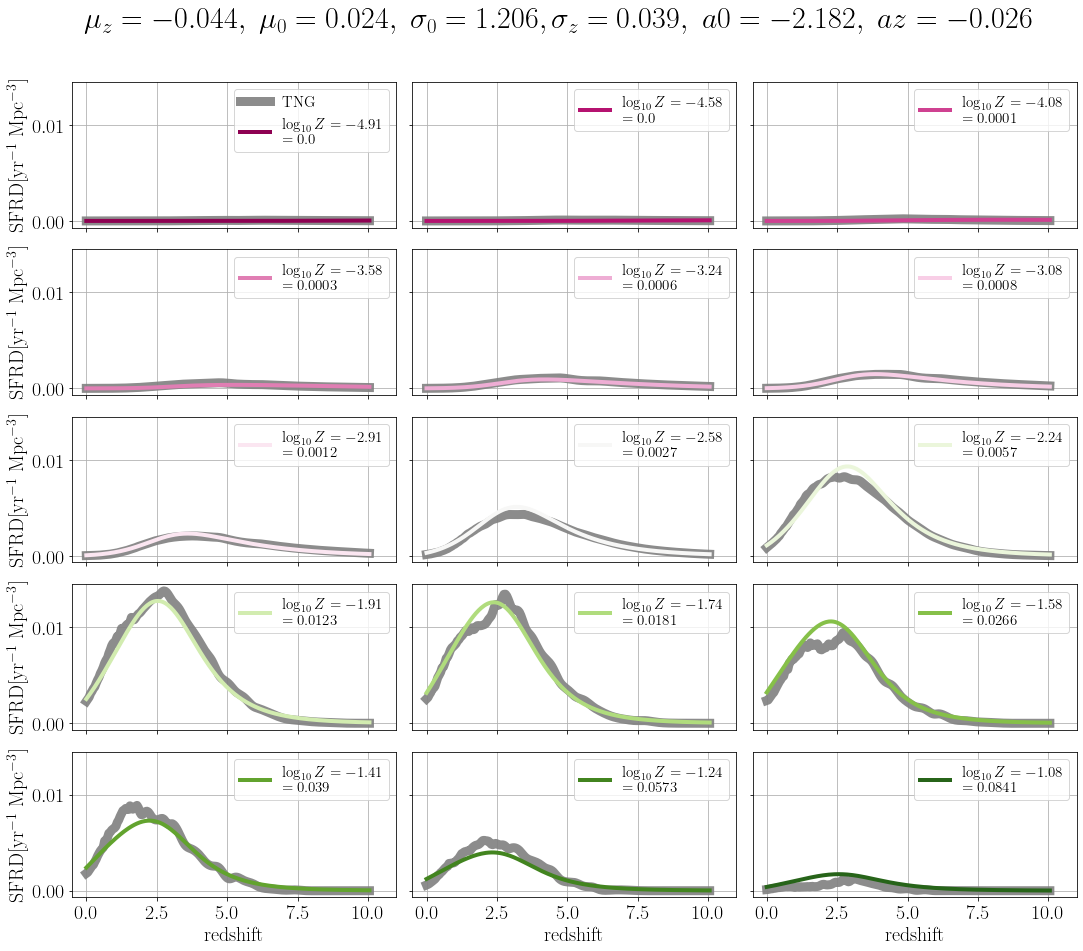

In [255]:

######################################
# BEST FITTING PARAMETERS:

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma0 =%s,sigmaz =%s, alpha=%s'% (muz_best,mu0_best,sigma0_best,sigmaz_best,alpha_best) )
print('\n')

######################################
normed       = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    print('obs_metal' , np.log10(obs_metal) )
    print(np.shape(z_new), np.shape(ynew), np.shape(SFRDnew) )
#     metallicity_indces = [30, 32, 34, 36, 38, 40,42,44,46,48,50,52,54,56,58]
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]
    
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]

######################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)

#####################################
# Get the SFR
sfr = Madau_Dickinson2014(obs_redshift, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


#####################################
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metallicity_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for Z, metal_i in enumerate(metallicity_indces):

    linestyles = ['-', ':', '--', '-.', ':']
    row  = int(floor(Z/3) )
    col  = Z - row*3
    #print('row, col', row, col)
    
    if Z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    ######################################
    # "OBSERVATIONS" = TNG np.log10(
    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[:,:], axis = -1)
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i]/obs_norm,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i],
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
        
    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr *dPdlogZ[:, metal_i]# Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        ax[row,col].plot(obs_redshift, dPdlogZ[:,metal_i] *step_logZ , lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
    else:
        ax[row,col].plot(obs_redshift, SFRD.value, lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
        
        
    ######################################
    # PLOT PARAMS
    ax[row,col].legend(fontsize = 15, loc='upper right')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-0.5, 11)
#     ax[row,col].set_ylim(0, 0.015)
#     ax[row,col].set_ylim(-10, -1)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\mathrm{redshift}$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a0=%s, \ az=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha0_best,3), np.round(alphaz_best,3) )
plt.suptitle(title, y = 0.95)


print('saving here',save_loc + 'TNGfit_redshift_slices.pdf')
plt.savefig(save_loc + 'TNGfit_metal_slices.pdf',  bbox_inches='tight')

plt.show()


# Plot different realizations of the SFR(z)

max value 0.087390701185364 solMass / (Mpc3 yr)  at x_max =  11.406496746978968 Gyr


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFR_tlookback.pdf


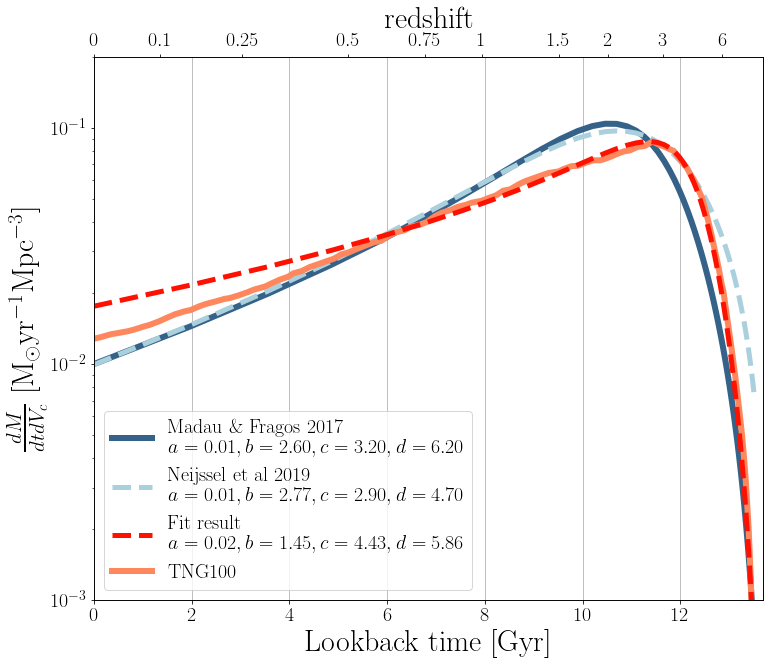

max value 0.087390701185364 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFR_redshift.pdf


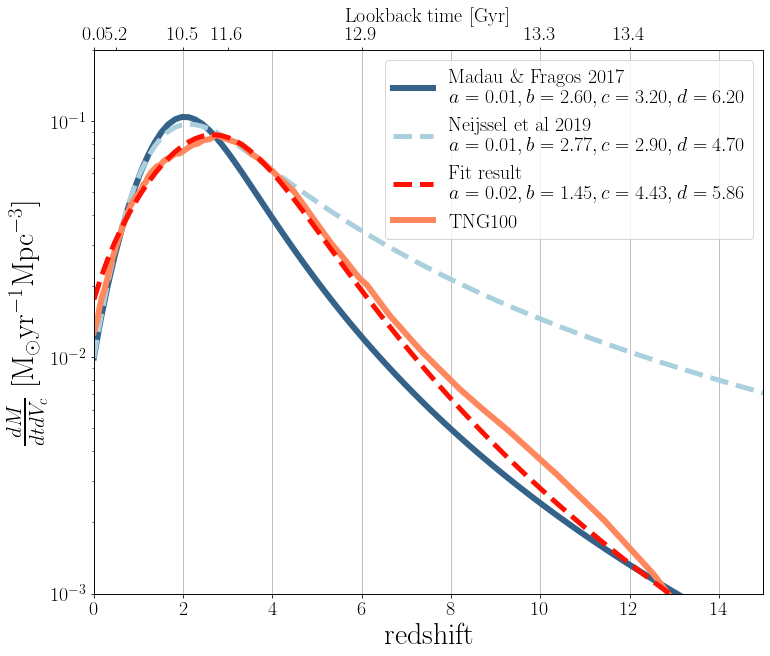

In [165]:

########################################################
# plot different SFRs
########################################################
def plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7):
    ########################################################
    # Start plotting
    fig, ax = plt.subplots(figsize=(12,10))

    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)


#     #default M&D 14
#     ax.plot(x1, Madau_Dickinson2014(redshift_list), 
#              label = 'Madau $\&$ Dickinson 2014\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.77,2.9,5.6)
#              , c = 'royalblue', ls = '--',lw=2)

    #default Madau & Fragos 17
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
             label = 'Madau $\&$ Fragos 2017\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
             , c = '#356288', ls = '-',lw=6)

    #default Coen
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
             label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
             , c = '#aacfdd', lw=5, ls = '--')


    # BEST FIT
    try:
        y_vals = Madau_Dickinson2014(redshift_list, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best)
        ax.plot(x1, y_vals,label = 'Fit result \n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best,sf_b_best,sf_c_best, sf_d_best), 
                 c = '#fe1100', lw=5, ls = '--', zorder =10)
        print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
    except:
        print('you probably havent run the optimzation yet..')



    ######################################
    # read TNG data
    ######################################
    with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
    # Convert SFR from sfr/box to sfr Mpc-3
    littleh  = 0.6774
    Rbox     = 75/littleh
    TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
    TNG_SFRD = TNG_SFRD.value
    # the last value of Lookbacktimes = 0, which is problematic for z calculation
    redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
    redshifts_TNG.append(0) # put redshift zero back at the end
    redshifts_TNG = np.array(redshifts_TNG)
    redshifts_TNG_inc = redshifts_TNG[::-1]
    ##########################################
    # "observed" TNG SFR(z)
    ##########################################
    if x_redshift:
        xobs  = redshifts_TNG
    else:
        xobs = Lookbacktimes

    ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG100', c = '#fe875d', lw=6)

    ##########################################
    # Checking normalization of what I will fit
    ##########################################################################
    center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
    sfr = Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz =-0.1, mu0 =0.025,
                                                  sigma_0=1.9,sigma_z=1.9, 
                                                  alpha_0 = -1.7, alpha_z = 0.,
                                                  metals=center_Zbin, redsh = redshifts_TNG_inc)
    if x_redshift:
        x  = redshifts
    else:
        x = cosmo.lookback_time(redshifts)

    # For each redshift in the TNG data:
    for redshift_i in range(len(redshifts)):
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ

    ##########################################################################
    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)


    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
    ax.set_ylim(1e-3, 0.2)
    ax.legend()
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    plt.show()

    
# time axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

# redshift axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 15)


# Same but in redshift space

In [170]:
                         
def metal_contours_TNG_zspace(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7,
                              obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################
    if add_TNG:
        ######################################
        if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
                MetalBins     = 10**f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]

            # Take the centers of the metallicity bins
            center_Zbin = np.log10(np.log10((MetalBins[:-1] + MetalBins[1:])/2. ) )

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = 75/littleh
            cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            cosmic_SFR = cosmic_SFR.value
            cosmic_SFR = cosmic_SFR.T
            
            #### TNG redshifts corresponding to these lookback times ### 
            # the last value of Lookbacktimes = 0, which is problematic for z calculation
            redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
            redshifts_TNG.append(0) # put redshift zero back at the end
            redshifts_TNG = np.array(redshifts_TNG)        

        else: 
            print('Using interpolated TNG')
            redshifts_TNG = obs_redshift
            center_Zbin   = obs_metal
            cosmic_SFR    = obs_SFRD    
            ax.set_yscale('log')
            
            
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed:
        norm_cosmic_SFR = np.sum(cosmic_SFR, axis = -1)
        cosmic_SFR = cosmic_SFR/norm_cosmic_SFR[:,np.newaxis]  
    
    # construct cmap
    flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#
    #         tng_color = ListedColormap(sns.color_palette(flatui).as_hex())
    # construct smooth cmap from one colour
    tng_color_map = sns.light_palette("#fe875d", as_cmap=True)
    # Pick 7 colours from this smooth colourmap
    tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )
    # Turn it back into a cmap
    tng_color     = ListedColormap(tng_colors)

    if add_TNG:
        TNG = ax.pcolormesh(redshifts_TNG, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)

        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap)
#                          locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_xlabel('$\mathrm{redshift}$', fontsize = 40)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 40)
    ax.set_yscale('log')
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    # Find loockback location for each of our redshifts
    redshift_tick_list = [0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
    # And annotate the tick labels :)
    ax2.set_xticks([z for z in redshift_tick_list])
    ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
#     ax.set_ylim(-5, 0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()

    




Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/RedshiftMetal_Planefid.pdf


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


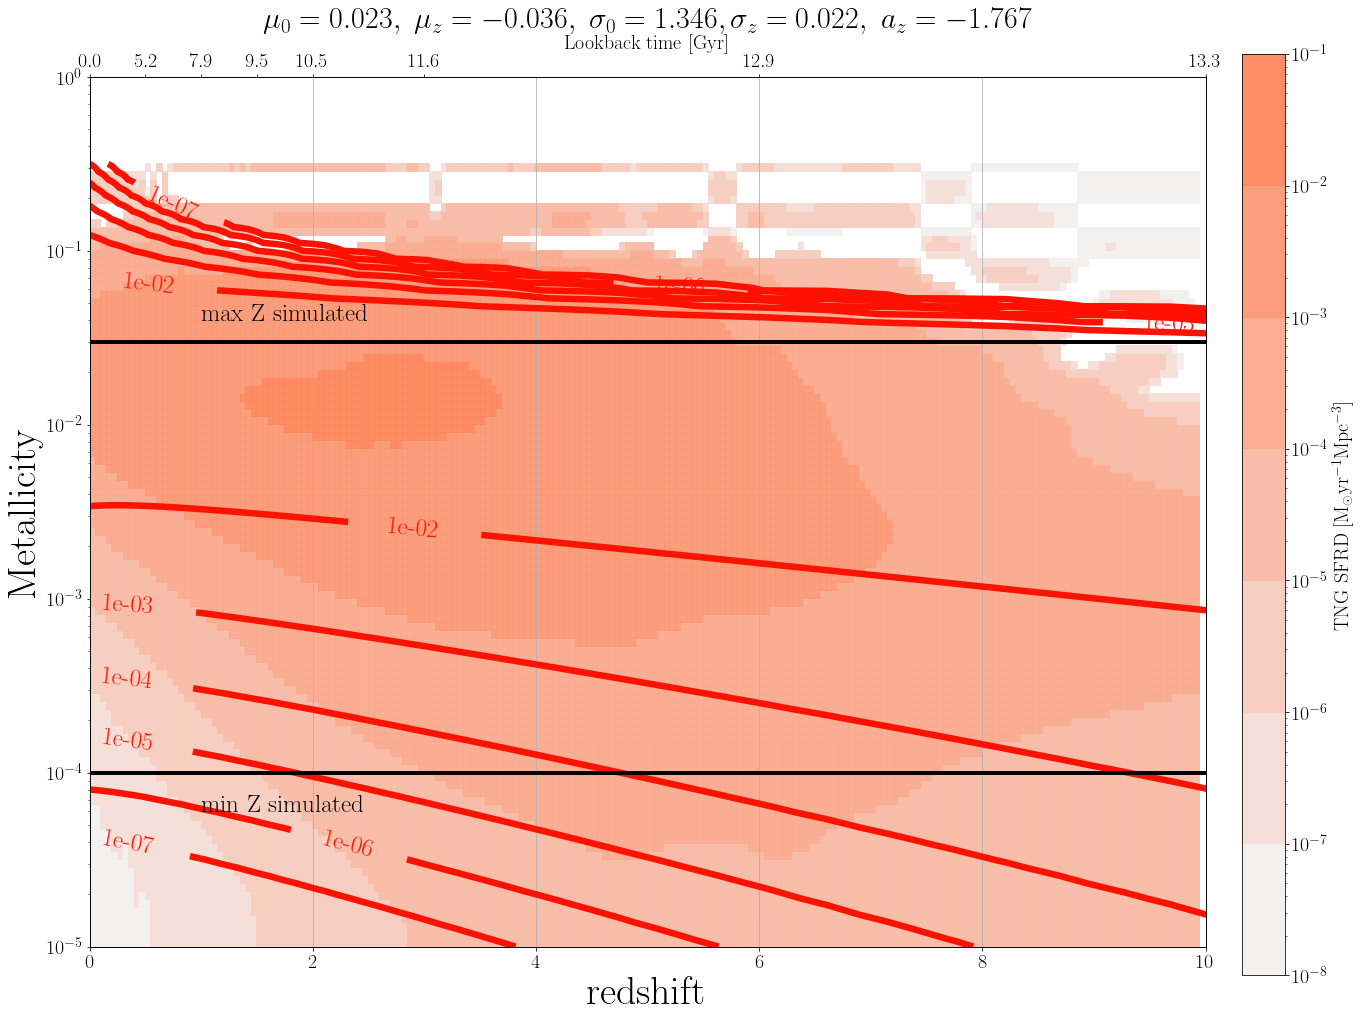

In [173]:
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alpha0_best,
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T #*sfr
# MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR, 
                          add_TNG=True, plot_contours = True, scatter = False, 
                          show_boundaries = True, boundkleur = 'k',
                          BBHcontour=False,show_obs = False,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'light:#fe1100_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,normed = False)
